In [1]:
!pip install openpyxl
!pip install scipy matplotlib fitter

import pandas as pd
import glob
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from scipy.stats import shapiro, kstest, anderson
from fitter import Fitter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
  Using cached fitter-1.7.1-py3-none-any.whl.metadata (8.2 kB)
Using cached fitter-1.7.1-py3-none-any.whl (26 kB)


In [8]:
# Function to load data from multiple Excel files into a single DataFrame
def load_data(city, years, months):
    df_list = []
    for year in years:
        for month in months:
            file_path = f"AQI_hourly_city_level_{city}_{year}_{month}_{city}_{month}_{year}.xlsx"
            try:
                df = pd.read_excel(file_path)
                df_list.append(df)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
    return pd.concat(df_list, ignore_index=True)

# Define the years and months
years = [2018, 2019, 2020, 2021, 2022, 2023]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Load data for Jaipur and Kolkata
df_jaipur = load_data('jaipur', years, months)
df_kolkata = load_data('kolkata', years, months)

print("Jaipur DataFrame:")
df_jaipur

# print("Kolkata DataFrame:")
# df_kolkata

Jaipur DataFrame:


Date  00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  05:00:00  \
0        1     226.0     228.0     234.0     253.0     218.0     220.0   
1        2     257.0     236.0     229.0     192.0     212.0     227.0   
2        3     273.0     266.0     263.0     265.0     260.0     250.0   
3        4     313.0     276.0     253.0     224.0     182.0     160.0   
4        5     197.0     173.0     165.0     151.0     140.0     145.0   
...    ...       ...       ...       ...       ...       ...       ...   
2186    27     226.0     207.0     189.0     180.0     159.0     170.0   
2187    28     259.0     257.0     229.0     204.0     230.0     243.0   
2188    29     325.0     327.0     323.0     327.0     340.0     323.0   
2189    30     203.0     213.0     215.0     220.0     188.0     170.0   
2190    31     242.0     234.0     229.0     240.0     236.0     230.0   

      06:00:00  07:00:00  08:00:00  ...  14:00:00  15:00:00  16:00:00  \
0        137.0     148.0     161.0  ...     150.0     134.0     111.0   
1        229.0     243.0     257.0  ...     163.0     140.0     130.0   
2        230.0     227.0     255.0  ...     201.0     164.0     141.0   
3        140.0     158.0     200.0  ...     119.0     137.0     149.0   
4        153.0     160.0     200.0  ...     144.0     158.0     134.0   
...        ...       ...       ...  ...       ...       ...       ...   
2186     206.0     191.0     253.0  ...     123.0     125.0     114.0   
2187     292.0     278.0     279.0  ...     153.0     145.0     141.0   
2188     301.0     302.0     285.0  ...     198.0     179.0     124.0   
2189     154.0     158.0     168.0  ...     194.0     162.0     162.0   
2190     233.0     222.0     226.0  ...     234.0     194.0     109.0   

      17:00:00  18:00:00  19:00:00  20:00:00  21:00:00  22:00:00  23:00:00  
0        110.0     112.0     120.0     157.0     226.0     238.0     251.0  
1        126.0     120.0     148.0     192.0     226.0     239.0     269.0  
2        127.0     134.0     203.0     304.0     349.0     404.0     375.0  
3        105.0     136.0     142.0     191.0     235.0     236.0     211.0  
4        126.0     146.0     199.0     238.0     272.0     299.0     300.0  
...        ...       ...       ...       ...       ...       ...       ...  
2186     107.0     123.0     169.0     340.0     325.0     272.0     249.0  
2187     128.0     162.0     224.0     309.0     317.0     294.0     308.0  
2188     157.0     131.0     141.0     206.0     182.0     192.0     200.0  
2189     177.0     186.0     205.0     262.0     287.0     276.0     222.0  
2190     115.0     174.0     212.0     270.0     286.0     297.0     294.0  

[2191 rows x 25 columns]

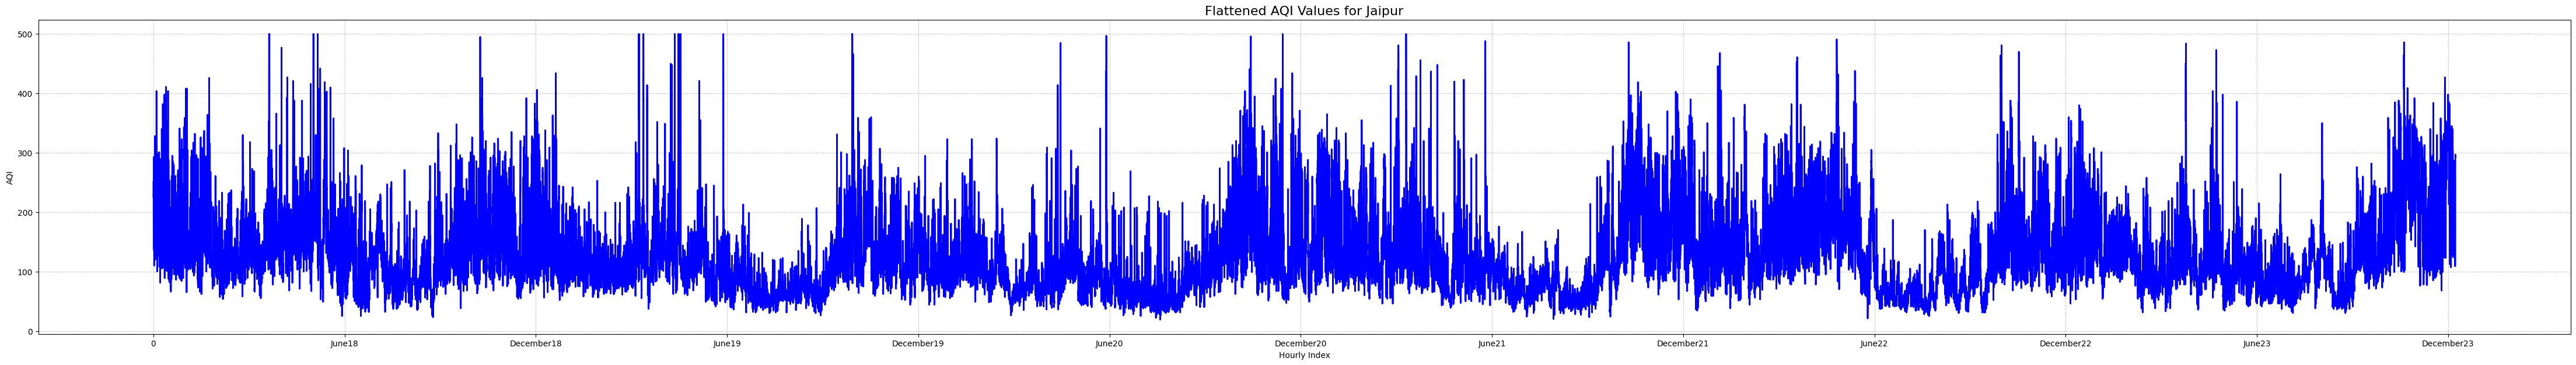

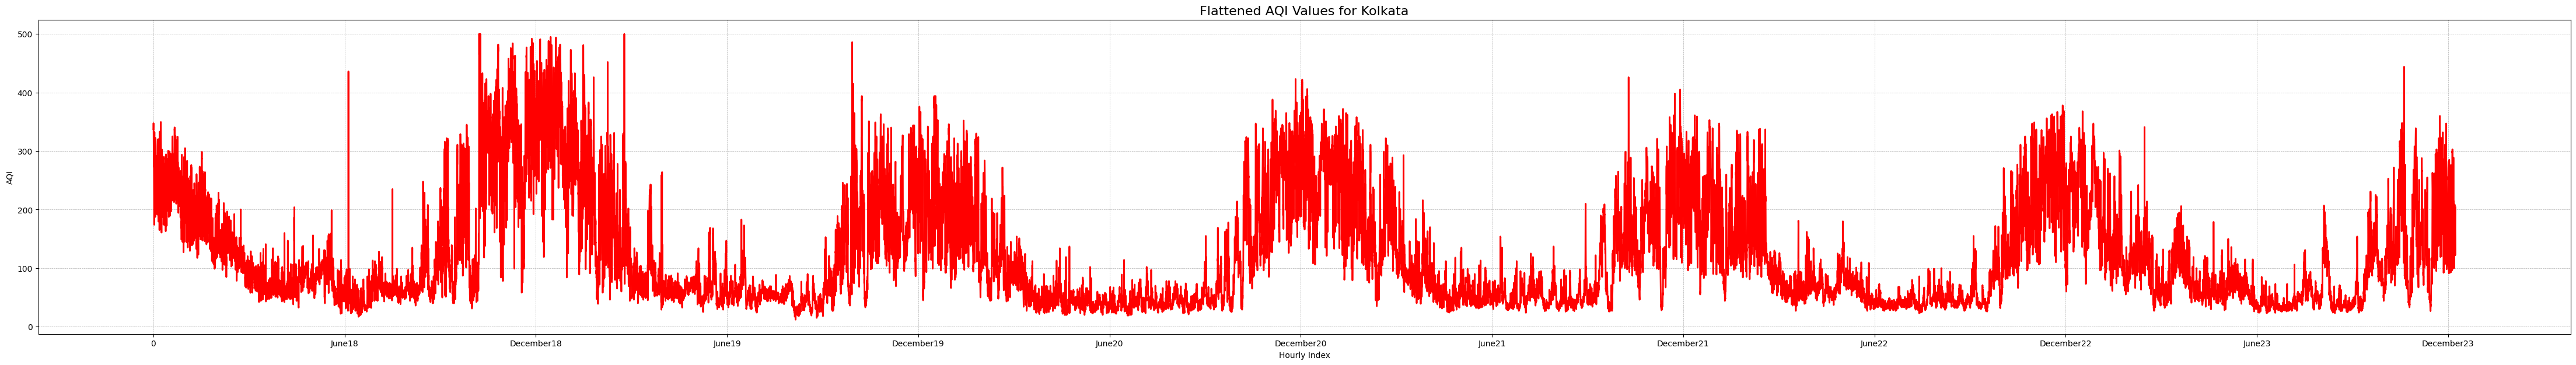

In [14]:
# Flatten the DataFrame values into a single list for Jaipur
flattened_values_jaipur = df_jaipur.iloc[:, 1:25].values.flatten()

# Create a new DataFrame with the flattened values for Jaipur
df_jaipur_flattened = pd.DataFrame(flattened_values_jaipur, columns=['AQI'])

# Set a larger figure size for better visibility
plt.figure(figsize=(56, 7))

# Plot the flattened AQI values for Jaipur
df_jaipur_flattened.plot(kind='line', title='Flattened AQI Values for Jaipur', ax=plt.gca(), legend=False, color='blue', linewidth=2)

# Customize the plot
plt.xlabel('Hourly Index')
plt.ylabel('AQI')
plt.grid(visible=True, linestyle='--', linewidth=0.5)

# Generate x-ticks for 0, June and December alternatively, starting with June18, December18, June19, and so on
xticks_labels = ['0']
for year in range(2018, 2024):
    xticks_labels.append(f"June{year % 100}")
    xticks_labels.append(f"December{year % 100}")

xticks_positions = [0] + [i * (182 * 24) for i in range(1, len(xticks_labels))]

plt.xticks(ticks=xticks_positions, labels=xticks_labels, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Flattened AQI Values for Jaipur', fontsize=16)

# Show the plot
plt.show()

# Flatten the DataFrame values into a single list for Kolkata
flattened_values_kolkata = df_kolkata.iloc[:, 1:25].values.flatten()

# Create a new DataFrame with the flattened values for Kolkata
df_kolkata_flattened = pd.DataFrame(flattened_values_kolkata, columns=['AQI'])

# Set a larger figure size for better visibility
plt.figure(figsize=(56, 7))

# Plot the flattened AQI values for Kolkata
df_kolkata_flattened.plot(kind='line', title='Flattened AQI Values for Kolkata', ax=plt.gca(), legend=False, color='red', linewidth=2)

# Customize the plot
plt.xlabel('Hourly Index')
plt.ylabel('AQI')
plt.grid(visible=True, linestyle='--', linewidth=0.5)

# Generate x-ticks for 0, June and December alternatively, starting with June18, December18, June19, and so on
plt.xticks(ticks=xticks_positions, labels=xticks_labels, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Flattened AQI Values for Kolkata', fontsize=16)

# Show the plot
plt.show()



In [15]:
# Save the whole data for Jaipur in different text files as single column vectors of length 365
for i in range(0, len(flattened_values_jaipur), 365):
    chunk = flattened_values_jaipur[i:i+365]
    np.savetxt(f'jaipur_values_{i//365 + 1}.txt', chunk, fmt='%f')

# Save the whole data for Kolkata in different text files as single column vectors of length 365
for i in range(0, len(flattened_values_kolkata), (365*24)):
    chunk = flattened_values_kolkata[i:i+365]
    np.savetxt(f'kolkata_values_{i//365 + 1}.txt', chunk, fmt='%f')

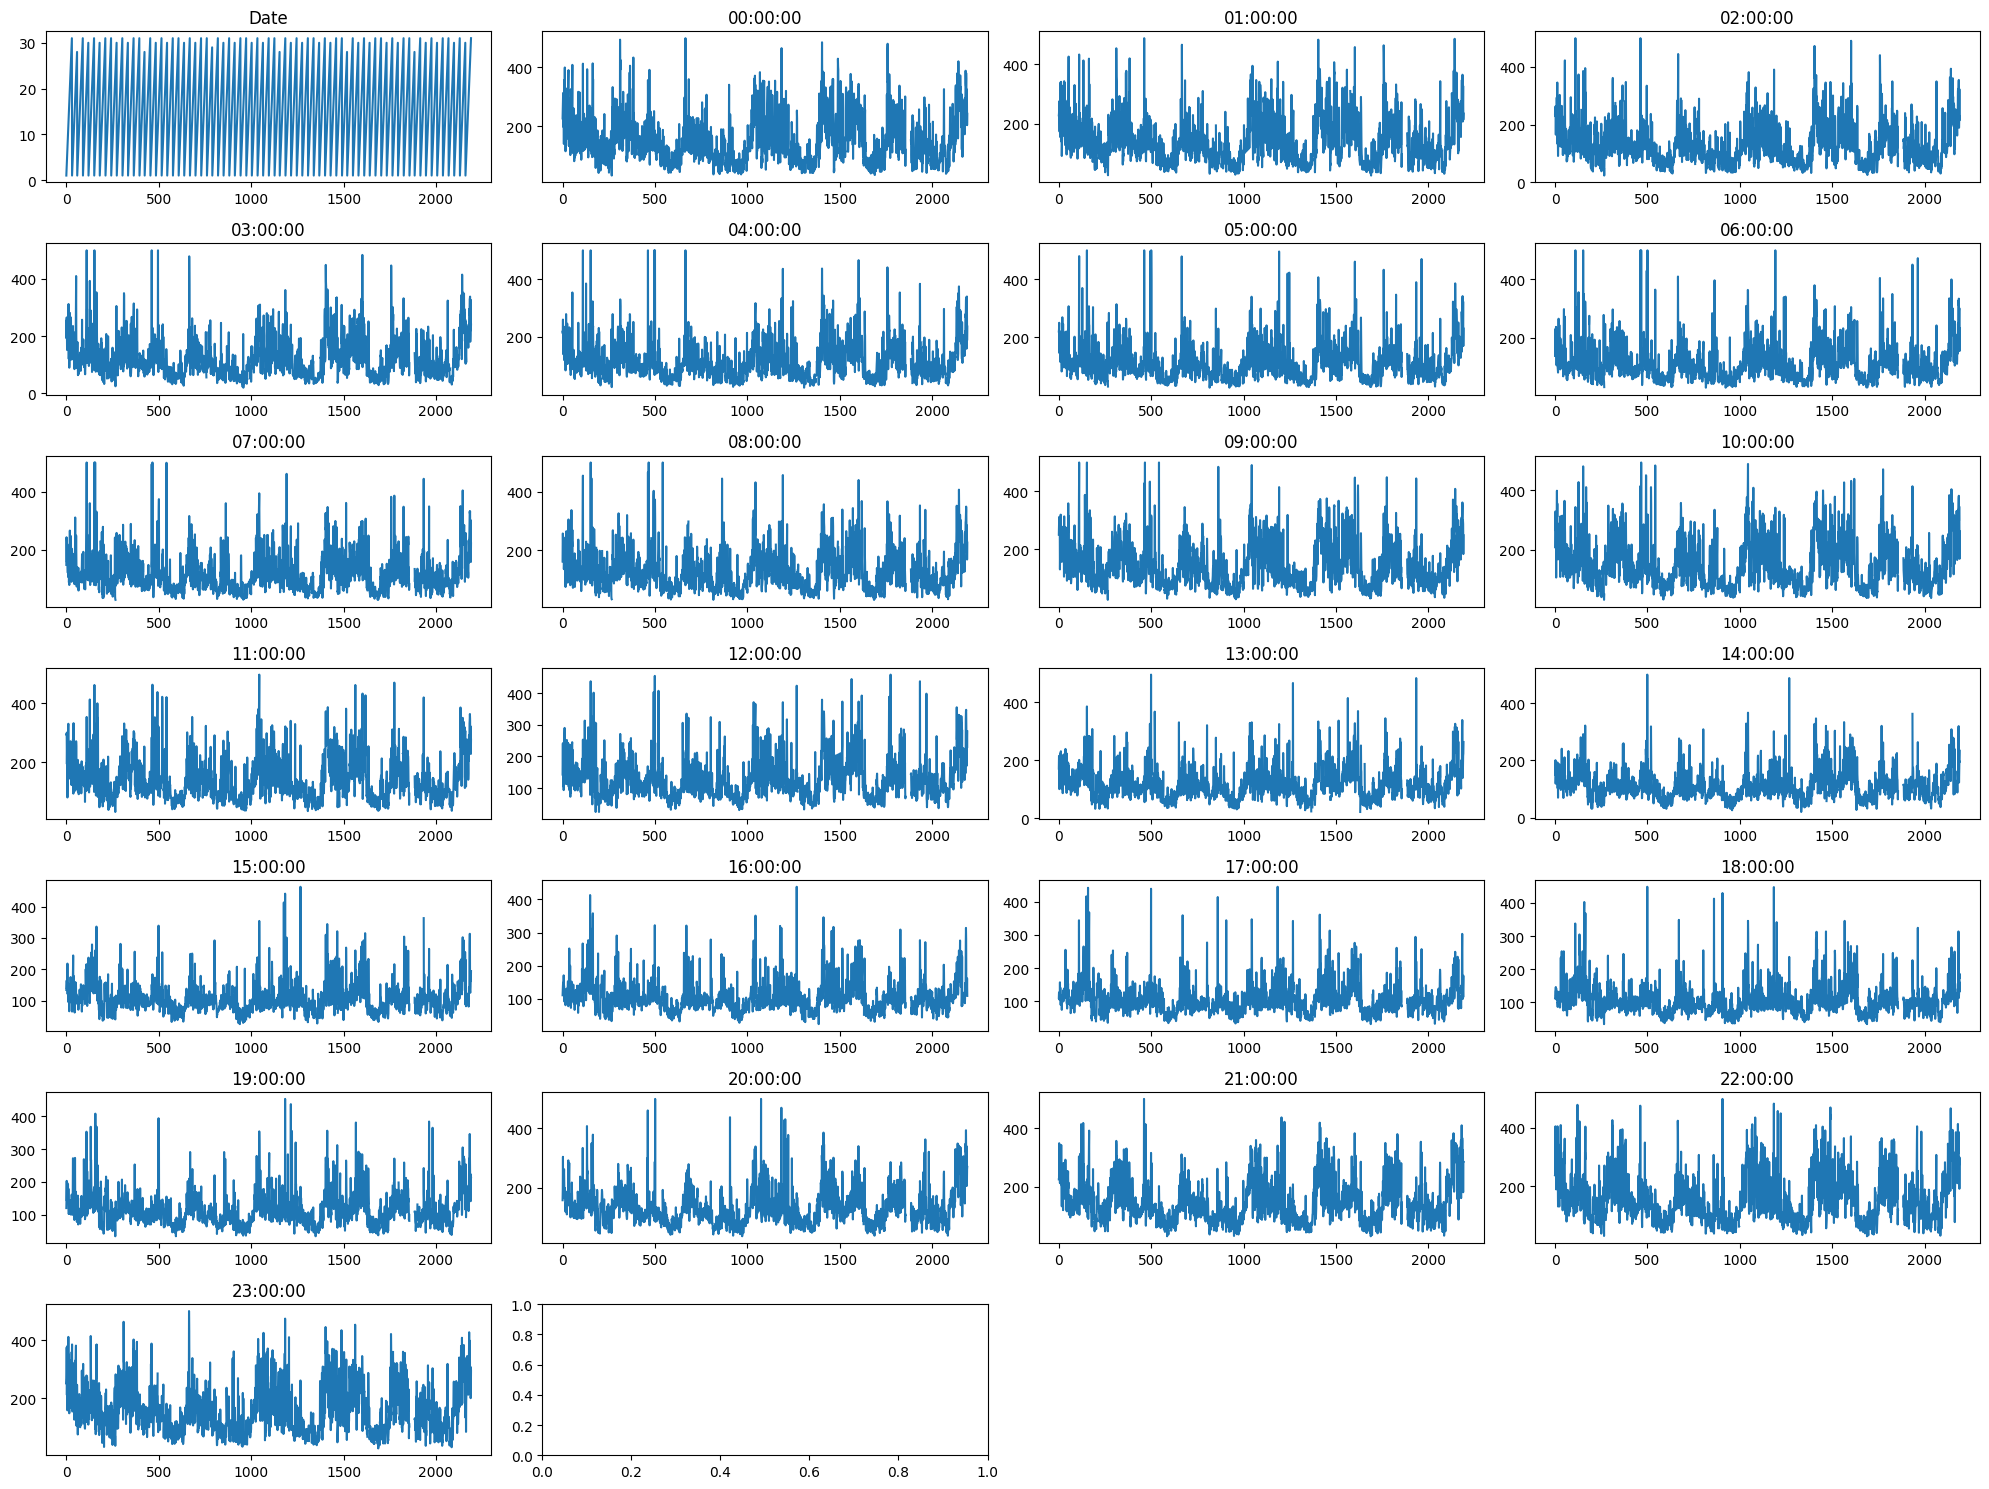

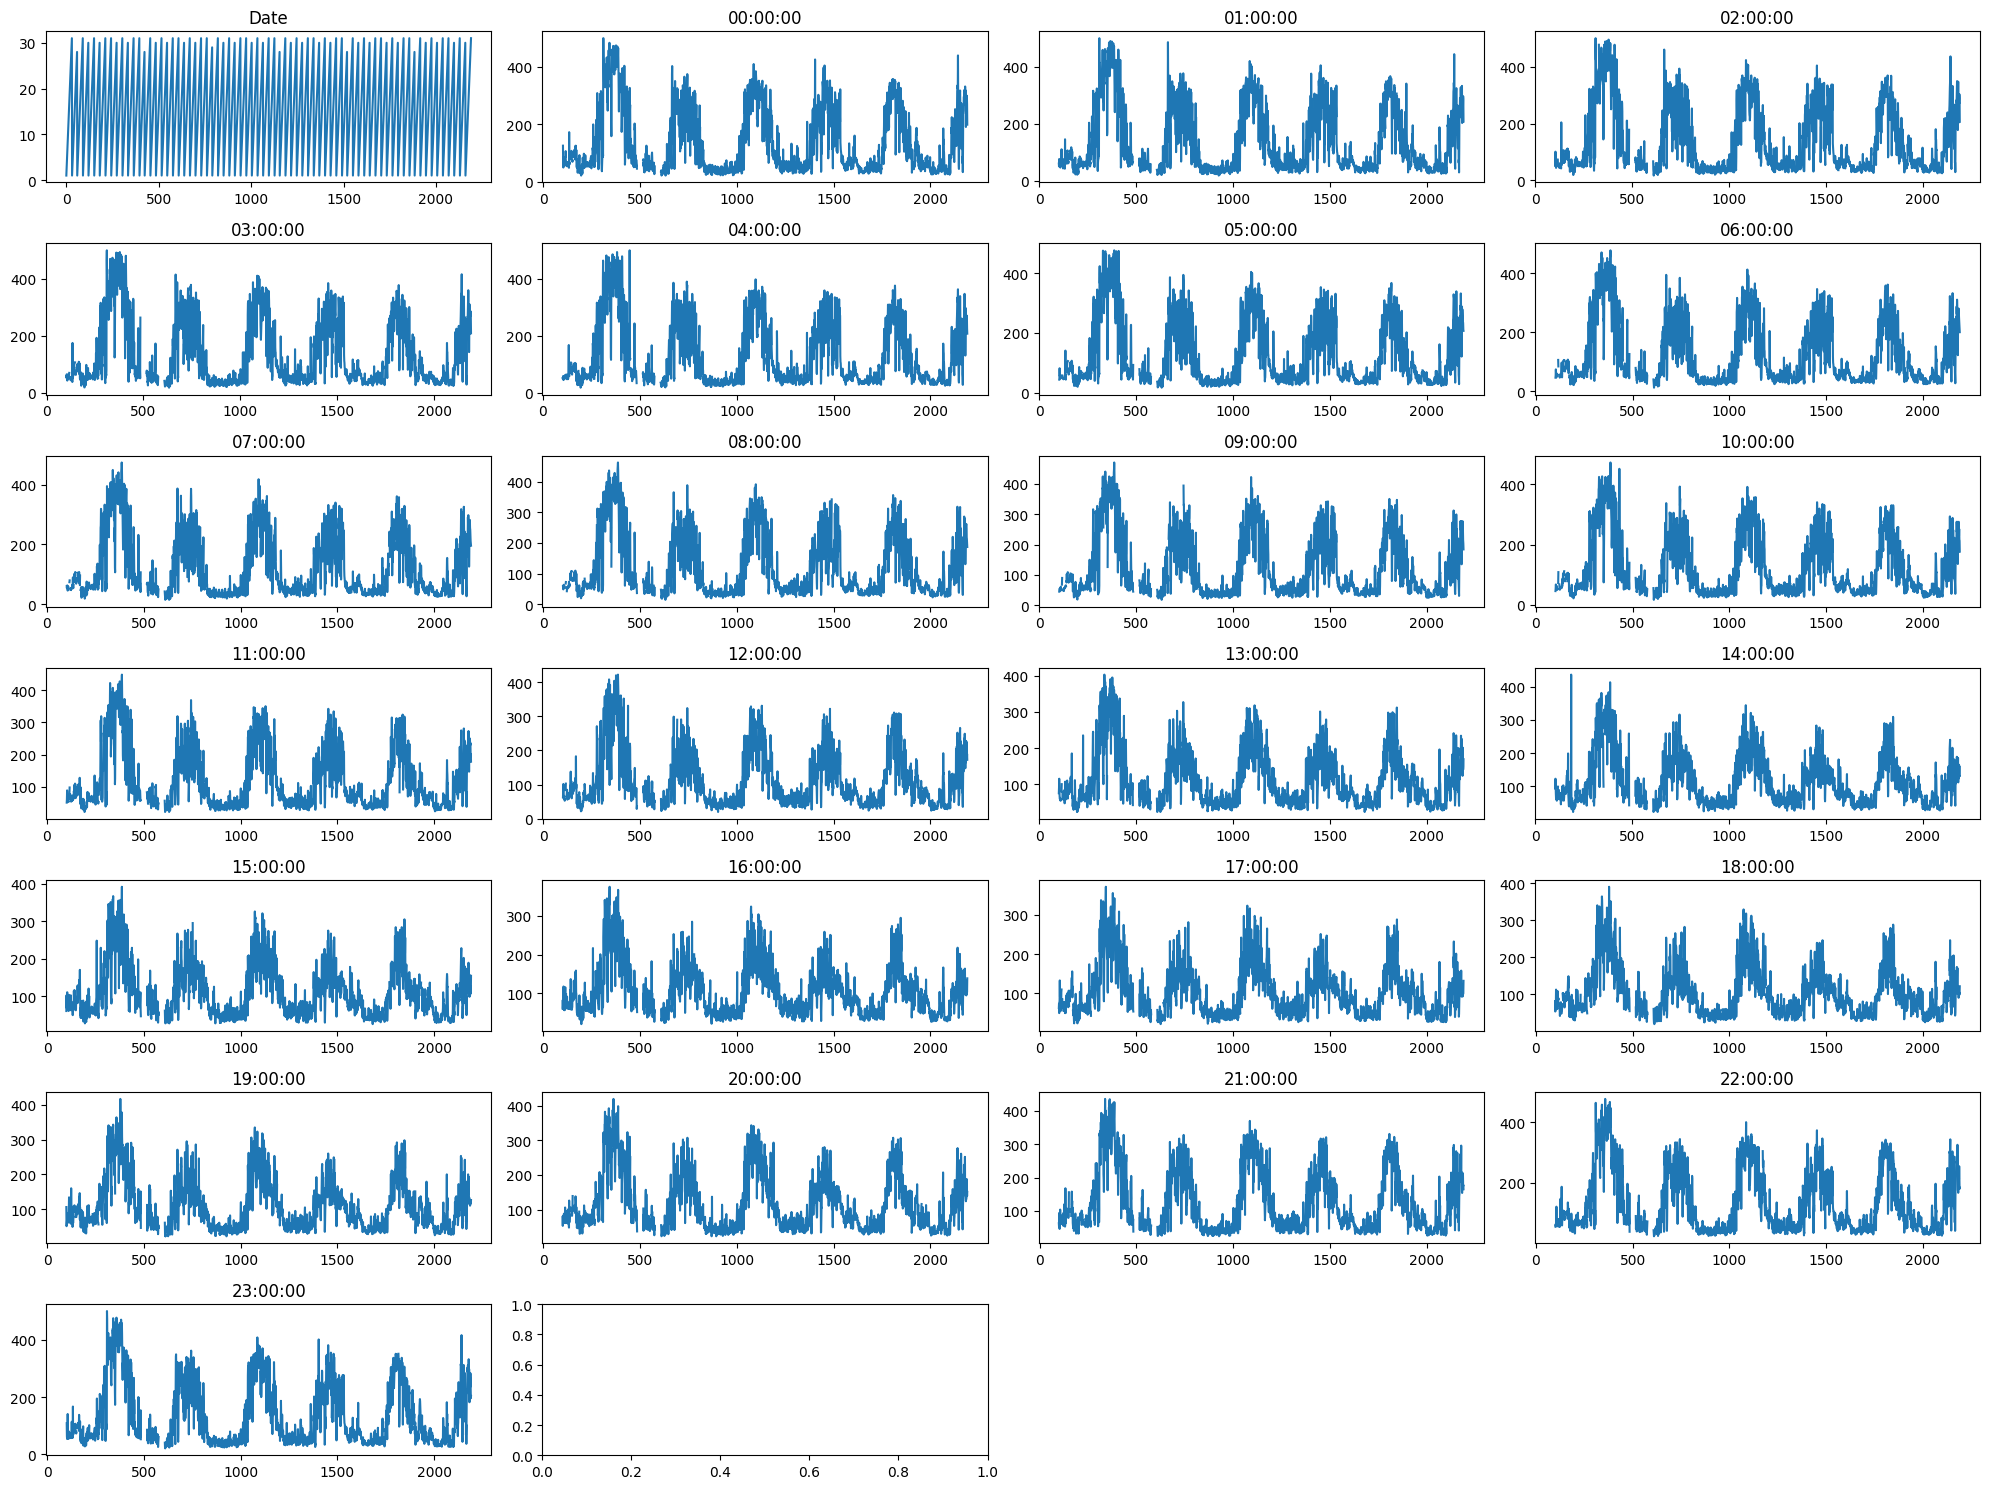

In [10]:
# Plot the whole data for Jaipur left to right and row by row
num_columns_jaipur = len(df_jaipur.columns)
fig, axs = plt.subplots(nrows=(num_columns_jaipur // 4) + 1, ncols=4, figsize=(20, 15))
axs = axs.flatten()

for i, column in enumerate(df_jaipur.columns):
    df_jaipur[column].plot(ax=axs[i], title=column)

# Hide any unused subplots
for j in range(i + 2, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Plot the whole data for Kolkata left to right and row by row
num_columns_kolkata = len(df_kolkata.columns)
fig, axs = plt.subplots(nrows=(num_columns_kolkata // 4) + 1, ncols=4, figsize=(20, 15))
axs = axs.flatten()

for i, column in enumerate(df_kolkata.columns):
    df_kolkata[column].plot(ax=axs[i], title=column)

# Hide any unused subplots
for j in range(i + 2, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [11]:
jaipur_nan_count = df_jaipur.isna().sum().sum()
kolkata_nan_count = df_kolkata.isna().sum().sum()

print(f"Total NaN values in Jaipur DataFrame: {jaipur_nan_count}")
print(f"Total NaN values in Kolkata DataFrame: {kolkata_nan_count}")

# Calculate daily AQI by averaging the 24 hourly values for each day
df_jaipur['Daily_AQI'] = df_jaipur.iloc[:, 1:25].mean(axis=1)
df_kolkata['Daily_AQI'] = df_kolkata.iloc[:, 1:25].mean(axis=1)

# Create a new column for month
df_jaipur['Month'] = 1
df_kolkata['Month'] = 1

# Initialize the month value
current_month_jaipur = 1
current_month_kolkata = 1

# Iterate over the rows to update the month value for Jaipur
for index, row in df_jaipur.iterrows():
    if row['Date'] == 1 and index != 0:
        current_month_jaipur += 1
        if current_month_jaipur > 12:
            current_month_jaipur = 1
    df_jaipur.at[index, 'Month'] = current_month_jaipur

# Iterate over the rows to update the month value for Kolkata
for index, row in df_kolkata.iterrows():
    if row['Date'] == 1 and index != 0:
        current_month_kolkata += 1
        if current_month_kolkata > 12:
            current_month_kolkata = 1
    df_kolkata.at[index, 'Month'] = current_month_kolkata

    # Create a new column for year
    df_jaipur['Year'] = 2018
    df_kolkata['Year'] = 2018

    # Initialize the year value
    current_year_jaipur = 2018
    current_year_kolkata = 2018

    # Iterate over the rows to update the year value for Jaipur
    for index, row in df_jaipur.iterrows():
        if row['Month'] == 1 and index != 0 and df_jaipur.at[index - 1, 'Month'] == 12:
            current_year_jaipur += 1
        df_jaipur.at[index, 'Year'] = current_year_jaipur

    # Iterate over the rows to update the year value for Kolkata
    for index, row in df_kolkata.iterrows():
        if row['Month'] == 1 and index != 0 and df_kolkata.at[index - 1, 'Month'] == 12:
            current_year_kolkata += 1
        df_kolkata.at[index, 'Year'] = current_year_kolkata

def fill_missing_values(df):
    hour_columns = [col for col in df.columns if col.startswith(('00:', '01:', '02:', '03:', '04:', '05:', '06:', '07:', '08:', '09:', '10:', '11:', '12:', '13:', '14:', '15:', '16:', '17:', '18:', '19:', '20:', '21:', '22:', '23:'))]

    def fill_row(row):
        for hour in hour_columns:
            if pd.isna(row[hour]):
                # Identify the same day, month, hour values across different years
                same_hour_values = df[(df['Month'] == row['Month']) & (df['Date'] == row['Date']) & (~df[hour].isna())][hour]

                # Compute mean if available
                if len(same_hour_values) > 0:
                    row[hour] = same_hour_values.mean()
                else:
                    # If no data available, assign an appropriate placeholder
                    row[hour] = "No Data Available"  # Or a fallback, e.g., row['Daily_AQI'], Monthly_AQI, etc.
        return row

    # Apply the function to each row
    df = df.apply(fill_row, axis=1)

    # Ensure all missing values are handled
    print(df.isna().sum())
    return df


df_jaipur = fill_missing_values(df_jaipur)
df_kolkata = fill_missing_values(df_kolkata)

Total NaN values in Jaipur DataFrame: 890
Total NaN values in Kolkata DataFrame: 4386
Date          0
00:00:00      0
01:00:00      0
02:00:00      0
03:00:00      0
04:00:00      0
05:00:00      0
06:00:00      0
07:00:00      0
08:00:00      0
09:00:00      0
10:00:00      0
11:00:00      0
12:00:00      0
13:00:00      0
14:00:00      0
15:00:00      0
16:00:00      0
17:00:00      0
18:00:00      0
19:00:00      0
20:00:00      0
21:00:00      0
22:00:00      0
23:00:00      0
Daily_AQI    28
Month         0
Year          0
dtype: int64
Date           0
00:00:00       0
01:00:00       0
02:00:00       0
03:00:00       0
04:00:00       0
05:00:00       0
06:00:00       0
07:00:00       0
08:00:00       0
09:00:00       0
10:00:00       0
11:00:00       0
12:00:00       0
13:00:00       0
14:00:00       0
15:00:00       0
16:00:00       0
17:00:00       0
18:00:00       0
19:00:00       0
20:00:00       0
21:00:00       0
22:00:00       0
23:00:00       0
Daily_AQI    167
Month      

In [12]:
jaipur_nan_count = df_jaipur.isna().sum().sum()
kolkata_nan_count = df_kolkata.isna().sum().sum()

print(f"Total NaN values in Jaipur DataFrame: {jaipur_nan_count}")
print(f"Total NaN values in Kolkata DataFrame: {kolkata_nan_count}")

# Calculate daily AQI by averaging the 24 hourly values for each day
df_jaipur['Daily_AQI'] = df_jaipur.iloc[:, 1:25].mean(axis=1)
df_kolkata['Daily_AQI'] = df_kolkata.iloc[:, 1:25].mean(axis=1)

# Create a new column for month
df_jaipur['Month'] = 1
df_kolkata['Month'] = 1

# Initialize the month value
current_month_jaipur = 1
current_month_kolkata = 1

# Iterate over the rows to update the month value for Jaipur
for index, row in df_jaipur.iterrows():
    if row['Date'] == 1 and index != 0:
        current_month_jaipur += 1
        if current_month_jaipur > 12:
            current_month_jaipur = 1
    df_jaipur.at[index, 'Month'] = current_month_jaipur

# Iterate over the rows to update the month value for Kolkata
for index, row in df_kolkata.iterrows():
    if row['Date'] == 1 and index != 0:
        current_month_kolkata += 1
        if current_month_kolkata > 12:
            current_month_kolkata = 1
    df_kolkata.at[index, 'Month'] = current_month_kolkata

    # Create a new column for year
    df_jaipur['Year'] = 2018
    df_kolkata['Year'] = 2018

    # Initialize the year value
    current_year_jaipur = 2018
    current_year_kolkata = 2018

    # Iterate over the rows to update the year value for Jaipur
    for index, row in df_jaipur.iterrows():
        if row['Month'] == 1 and index != 0 and df_jaipur.at[index - 1, 'Month'] == 12:
            current_year_jaipur += 1
        df_jaipur.at[index, 'Year'] = current_year_jaipur

    # Iterate over the rows to update the year value for Kolkata
    for index, row in df_kolkata.iterrows():
        if row['Month'] == 1 and index != 0 and df_kolkata.at[index - 1, 'Month'] == 12:
            current_year_kolkata += 1
        df_kolkata.at[index, 'Year'] = current_year_kolkata

Total NaN values in Jaipur DataFrame: 28
Total NaN values in Kolkata DataFrame: 167


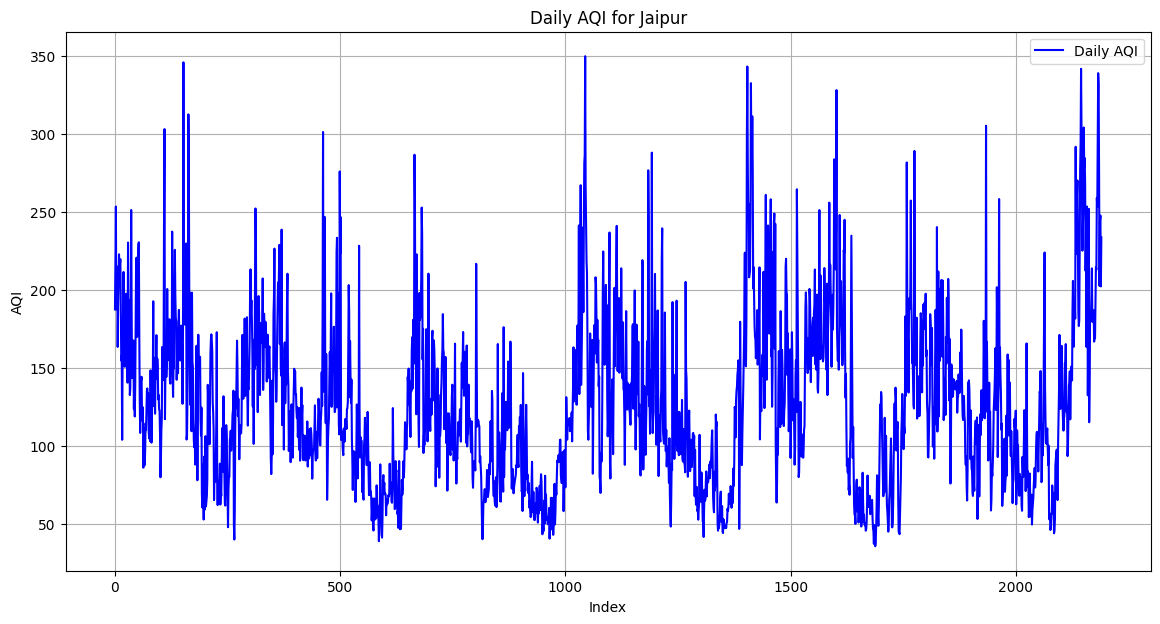

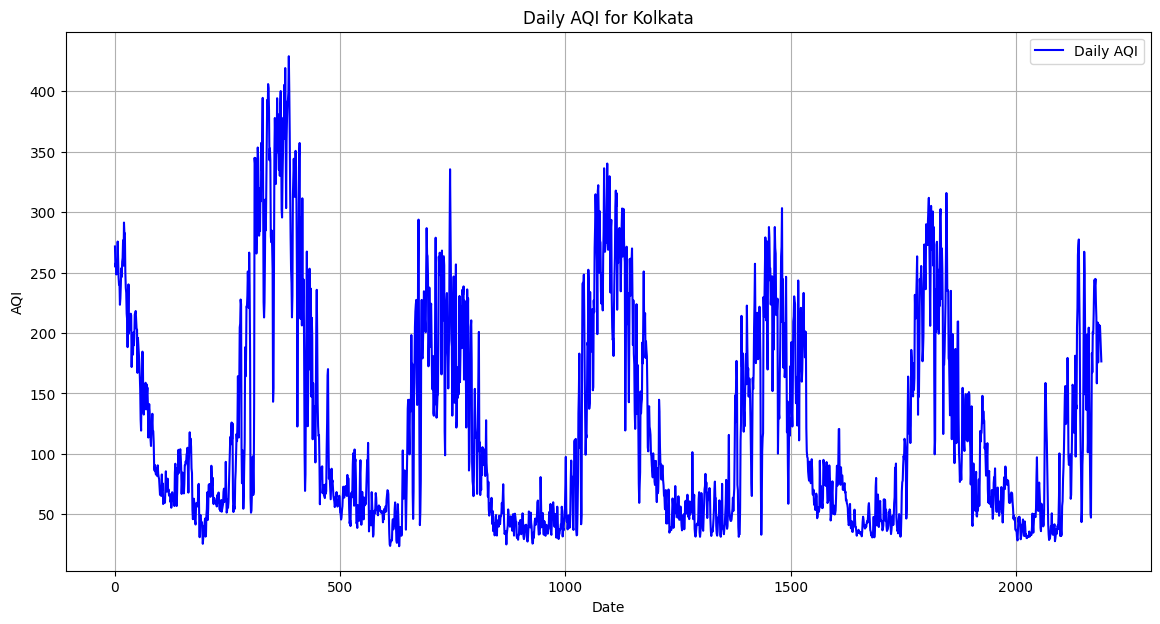

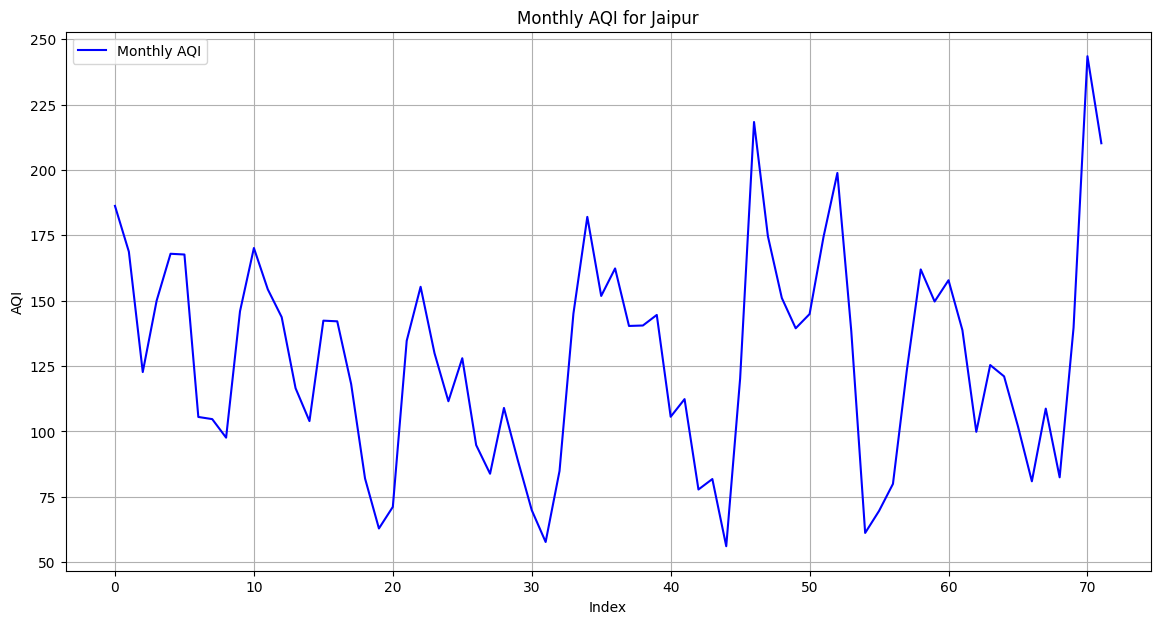

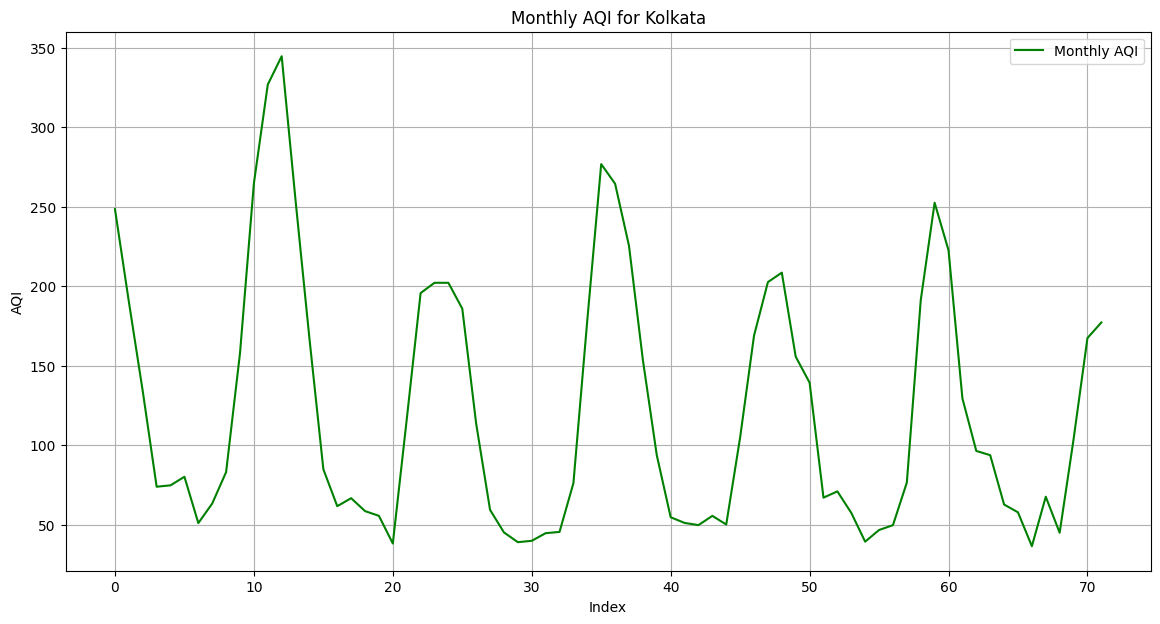

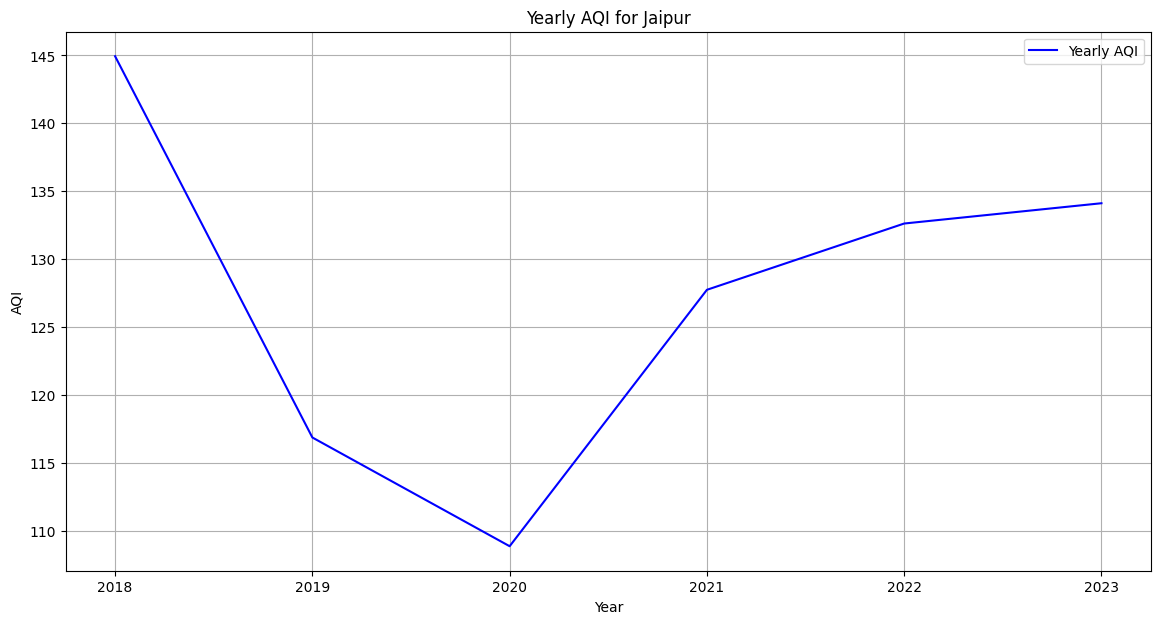

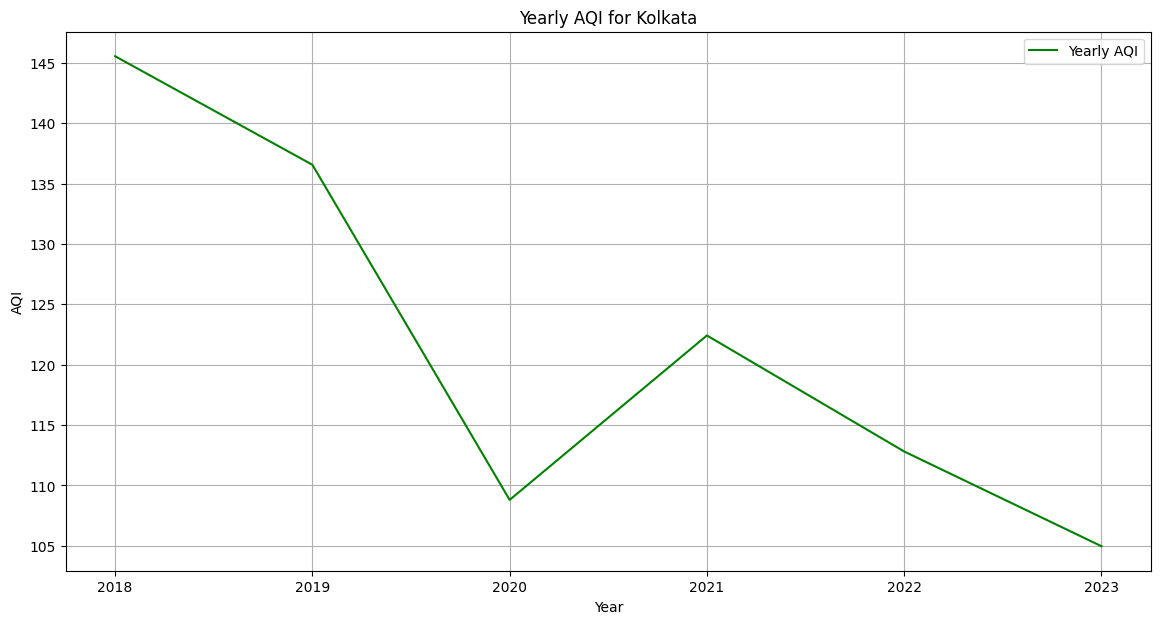

In [13]:
# Calculate monthly AQI by averaging the daily AQI values for each month
df_jaipur['Monthly_AQI'] = df_jaipur.groupby(['Year', 'Month'])['Daily_AQI'].transform('mean')
df_kolkata['Monthly_AQI'] = df_kolkata.groupby(['Year', 'Month'])['Daily_AQI'].transform('mean')

# Calculate yearly AQI by averaging the daily AQI values for each year
df_jaipur['Yearly_AQI'] = df_jaipur.groupby('Year')['Daily_AQI'].transform('mean')
df_kolkata['Yearly_AQI'] = df_kolkata.groupby('Year')['Daily_AQI'].transform('mean')

# Extract the monthly AQI into another array
monthly_aqi_jaipur = df_jaipur[['Year', 'Month', 'Monthly_AQI']].drop_duplicates().reset_index(drop=True)
monthly_aqi_kolkata = df_kolkata[['Year', 'Month', 'Monthly_AQI']].drop_duplicates().reset_index(drop=True)

# Plot Daily AQI for Jaipur
plt.figure(figsize=(14, 7))
plt.plot(df_jaipur.index, df_jaipur['Daily_AQI'], label='Daily AQI', color='blue')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.title('Daily AQI for Jaipur')
plt.legend()
plt.grid(True)
plt.show()

# Plot Daily AQI for Kolkata
plt.figure(figsize=(14, 7))
plt.plot(df_kolkata.index, df_kolkata['Daily_AQI'], label='Daily AQI', color='blue')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Daily AQI for Kolkata')
plt.legend()
plt.grid(True)
plt.show()

# Plot Monthly AQI for Jaipur
plt.figure(figsize=(14, 7))
plt.plot(monthly_aqi_jaipur.index, monthly_aqi_jaipur['Monthly_AQI'], label='Monthly AQI', color='blue')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.title('Monthly AQI for Jaipur')
plt.legend()
plt.grid(True)
plt.show()

# Plot Monthly AQI for Kolkata
plt.figure(figsize=(14, 7))
plt.plot(monthly_aqi_kolkata.index, monthly_aqi_kolkata['Monthly_AQI'], label='Monthly AQI', color='green')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.title('Monthly AQI for Kolkata')
plt.legend()
plt.grid(True)
plt.show()

# Extract the yearly AQI into another array
yearly_aqi_jaipur = df_jaipur[['Year', 'Yearly_AQI']].drop_duplicates().reset_index(drop=True)
yearly_aqi_kolkata = df_kolkata[['Year', 'Yearly_AQI']].drop_duplicates().reset_index(drop=True)

# Plot Yearly AQI for Jaipur
plt.figure(figsize=(14, 7))
plt.plot(yearly_aqi_jaipur['Year'], yearly_aqi_jaipur['Yearly_AQI'], label='Yearly AQI', color='blue')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.title('Yearly AQI for Jaipur')
plt.legend()
plt.grid(True)
plt.show()

# Plot Yearly AQI for Kolkata
plt.figure(figsize=(14, 7))
plt.plot(yearly_aqi_kolkata['Year'], yearly_aqi_kolkata['Yearly_AQI'], label='Yearly AQI', color='green')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.title('Yearly AQI for Kolkata')
plt.legend()
plt.grid(True)
plt.show()

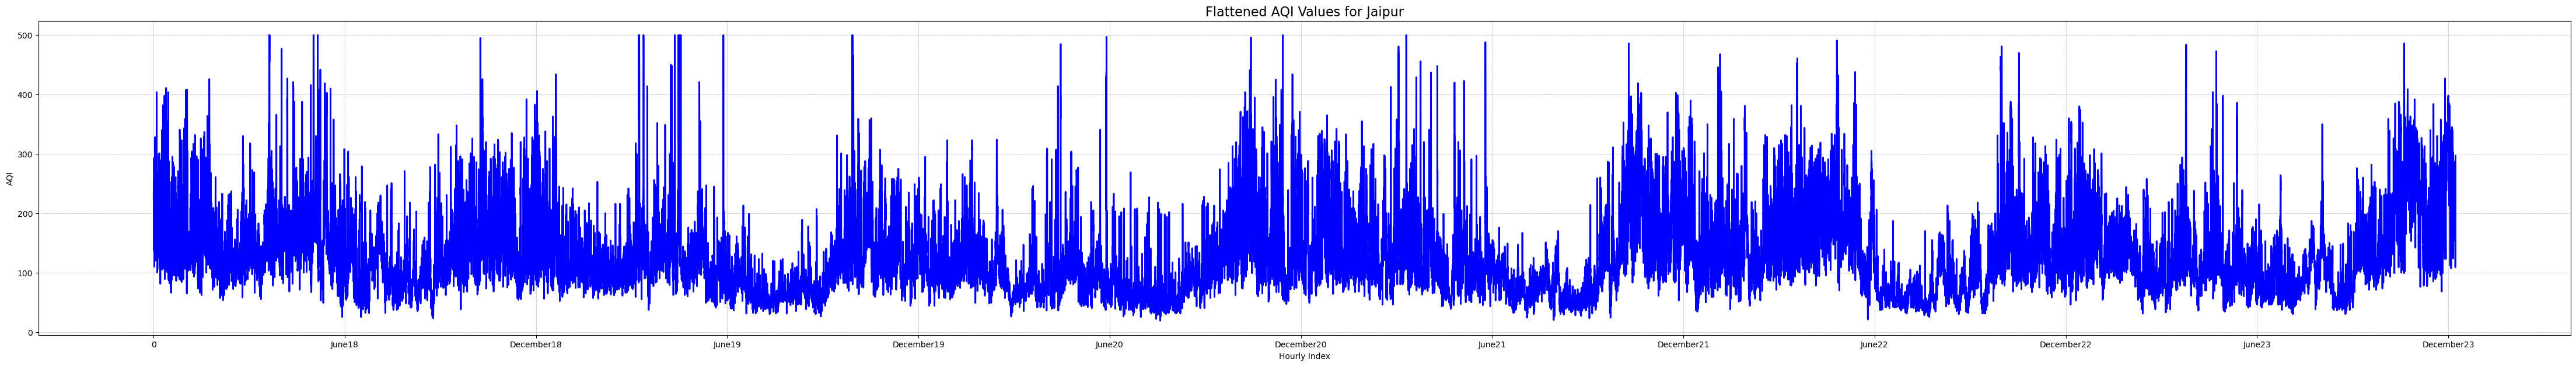

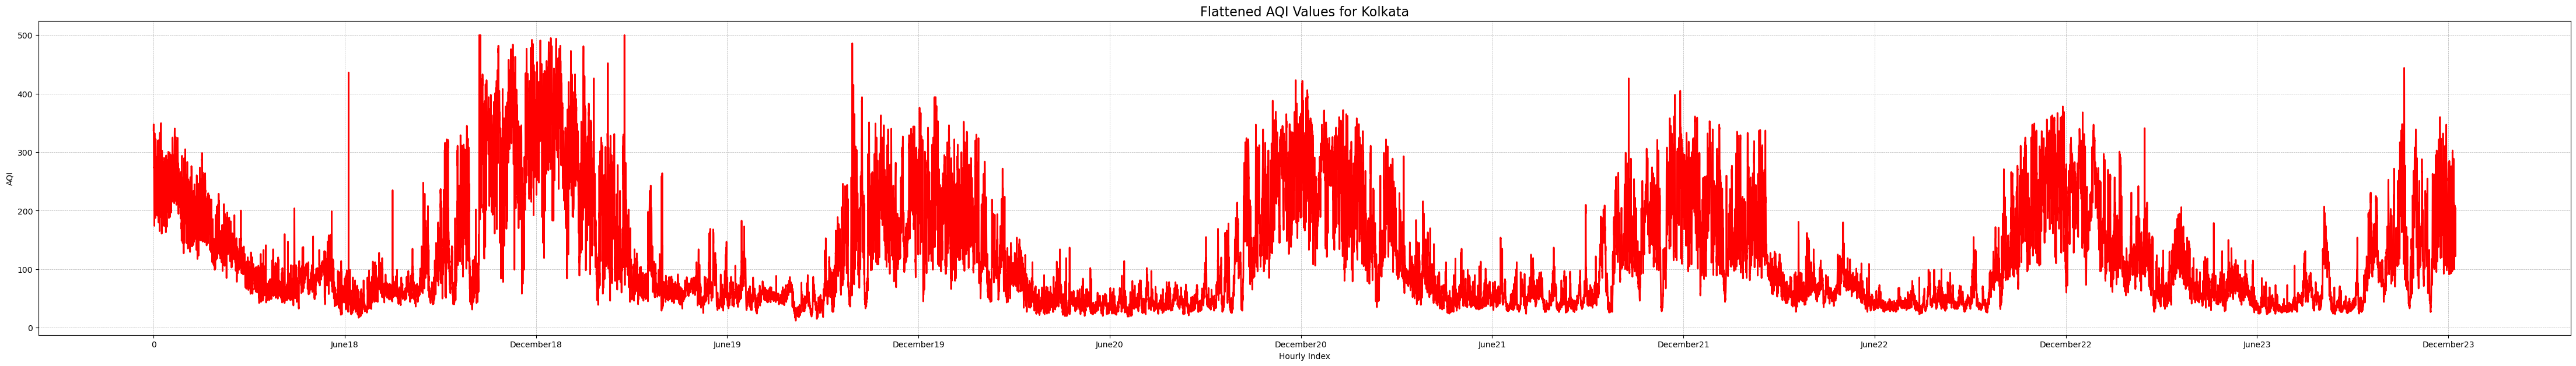

In [9]:
# Flatten the DataFrame values into a single list for Jaipur
flattened_values_jaipur = df_jaipur.iloc[:, 1:25].values.flatten()

# Create a new DataFrame with the flattened values for Jaipur
df_jaipur_flattened = pd.DataFrame(flattened_values_jaipur, columns=['AQI'])

# Set a larger figure size for better visibility
plt.figure(figsize=(56, 7))

# Plot the flattened AQI values for Jaipur
df_jaipur_flattened.plot(kind='line', title='Flattened AQI Values for Jaipur', ax=plt.gca(), legend=False, color='blue', linewidth=2)

# Customize the plot
plt.xlabel('Hourly Index')
plt.ylabel('AQI')
plt.grid(visible=True, linestyle='--', linewidth=0.5)

# Generate x-ticks for 0, June and December alternatively, starting with June18, December18, June19, and so on
xticks_labels = ['0']
for year in range(2018, 2024):
    xticks_labels.append(f"June{year % 100}")
    xticks_labels.append(f"December{year % 100}")

xticks_positions = [0] + [i * (182 * 24) for i in range(1, len(xticks_labels))]

plt.xticks(ticks=xticks_positions, labels=xticks_labels, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Flattened AQI Values for Jaipur', fontsize=16)

# Show the plot
plt.show()

# Flatten the DataFrame values into a single list for Kolkata
flattened_values_kolkata = df_kolkata.iloc[:, 1:25].values.flatten()

# Create a new DataFrame with the flattened values for Kolkata
df_kolkata_flattened = pd.DataFrame(flattened_values_kolkata, columns=['AQI'])

# Set a larger figure size for better visibility
plt.figure(figsize=(56, 7))

# Plot the flattened AQI values for Kolkata
df_kolkata_flattened.plot(kind='line', title='Flattened AQI Values for Kolkata', ax=plt.gca(), legend=False, color='red', linewidth=2)

# Customize the plot
plt.xlabel('Hourly Index')
plt.ylabel('AQI')
plt.grid(visible=True, linestyle='--', linewidth=0.5)

# Generate x-ticks for 0, June and December alternatively, starting with June18, December18, June19, and so on
plt.xticks(ticks=xticks_positions, labels=xticks_labels, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Flattened AQI Values for Kolkata', fontsize=16)

# Show the plot
plt.show()

In [10]:
def analyze_aqi_all_rows(dataframe):
    """
    Analyze AQI distributions for all rows in the dataset and summarize:
    - Number of rows classified as "normal" by statistical tests.
    - Best-fit distributions for all rows.

    Args:
    - dataframe (DataFrame): AQI data with hourly columns.

    Returns:
    - Summary dictionary with counts for normality and best-fit distributions.
    """
    # Initialize counters
    normal_by_shapiro = 0
    normal_by_ks = 0
    normal_by_anderson = 0
    best_fit_counts = {}
    valid_rows_count = 0

    # Iterate through all rows
    for idx, row in dataframe.iterrows():
        hourly_aqi = row[1:25].dropna().values  # Adjust column selection if necessary

        # Skip rows with fewer than 3 data points
        if len(hourly_aqi) < 3:
            continue

        valid_rows_count += 1

        # --- Normality Tests ---
        # Shapiro-Wilk Test
        shapiro_test = shapiro(hourly_aqi)
        if shapiro_test.pvalue > 0.05:
            normal_by_shapiro += 1

        # Kolmogorov-Smirnov Test
        mu, std = np.mean(hourly_aqi), np.std(hourly_aqi)
        ks_test = kstest(hourly_aqi, 'norm', args=(mu, std))
        if ks_test.pvalue > 0.05:
            normal_by_ks += 1

        # Anderson-Darling Test
        ad_test = anderson(hourly_aqi, dist='norm')
        if ad_test.statistic <= ad_test.critical_values[2]:  # 5% significance level
            normal_by_anderson += 1

        # --- Best Fit Distribution ---
        f = Fitter(hourly_aqi, distributions=['norm', 'expon', 'gamma', 'lognorm', 'weibull_min'])
        f.fit()
        best_fit = f.get_best(method='sumsquare_error')
        best_fit_name = list(best_fit.keys())[0]

        # Update best-fit counts
        if best_fit_name in best_fit_counts:
            best_fit_counts[best_fit_name] += 1
        else:
            best_fit_counts[best_fit_name] = 1

    # Create summary
    summary = {
        'total_valid_rows': valid_rows_count,
        'normal_by_shapiro': normal_by_shapiro,
        'normal_by_ks': normal_by_ks,
        'normal_by_anderson': normal_by_anderson,
        'best_fit_counts': best_fit_counts
    }

    return summary

# Example Usage
summary_results = analyze_aqi_all_rows(df_jaipur)
print("Summary of AQI Distribution Analysis:")
print(f"Total valid rows analyzed: {summary_results['total_valid_rows']}")
print(f"Normal by Shapiro-Wilk: {summary_results['normal_by_shapiro']}")
print(f"Normal by Kolmogorov-Smirnov: {summary_results['normal_by_ks']}")
print(f"Normal by Anderson-Darling: {summary_results['normal_by_anderson']}")
print("Best-Fit Distribution Counts:")
for dist, count in summary_results['best_fit_counts'].items():
    print(f"{dist}: {count}")

summary_results = analyze_aqi_all_rows(df_kolkata)
print("Summary of AQI Distribution Analysis:")
print(f"Total valid rows analyzed: {summary_results['total_valid_rows']}")
print(f"Normal by Shapiro-Wilk: {summary_results['normal_by_shapiro']}")
print(f"Normal by Kolmogorov-Smirnov: {summary_results['normal_by_ks']}")
print(f"Normal by Anderson-Darling: {summary_results['normal_by_anderson']}")
print("Best-Fit Distribution Counts:")
for dist, count in summary_results['best_fit_counts'].items():
    print(f"{dist}: {count}")

Summary of AQI Distribution Analysis:
Total valid rows analyzed: 2191
Normal by Shapiro-Wilk: 1098
Normal by Kolmogorov-Smirnov: 2048
Normal by Anderson-Darling: 1127
Best-Fit Distribution Counts:
expon: 322
weibull_min: 840
norm: 205
gamma: 243
lognorm: 581
Summary of AQI Distribution Analysis:
Total valid rows analyzed: 2191
Normal by Shapiro-Wilk: 1042
Normal by Kolmogorov-Smirnov: 2082
Normal by Anderson-Darling: 1038
Best-Fit Distribution Counts:
weibull_min: 1059
norm: 150
expon: 349
lognorm: 413
gamma: 220


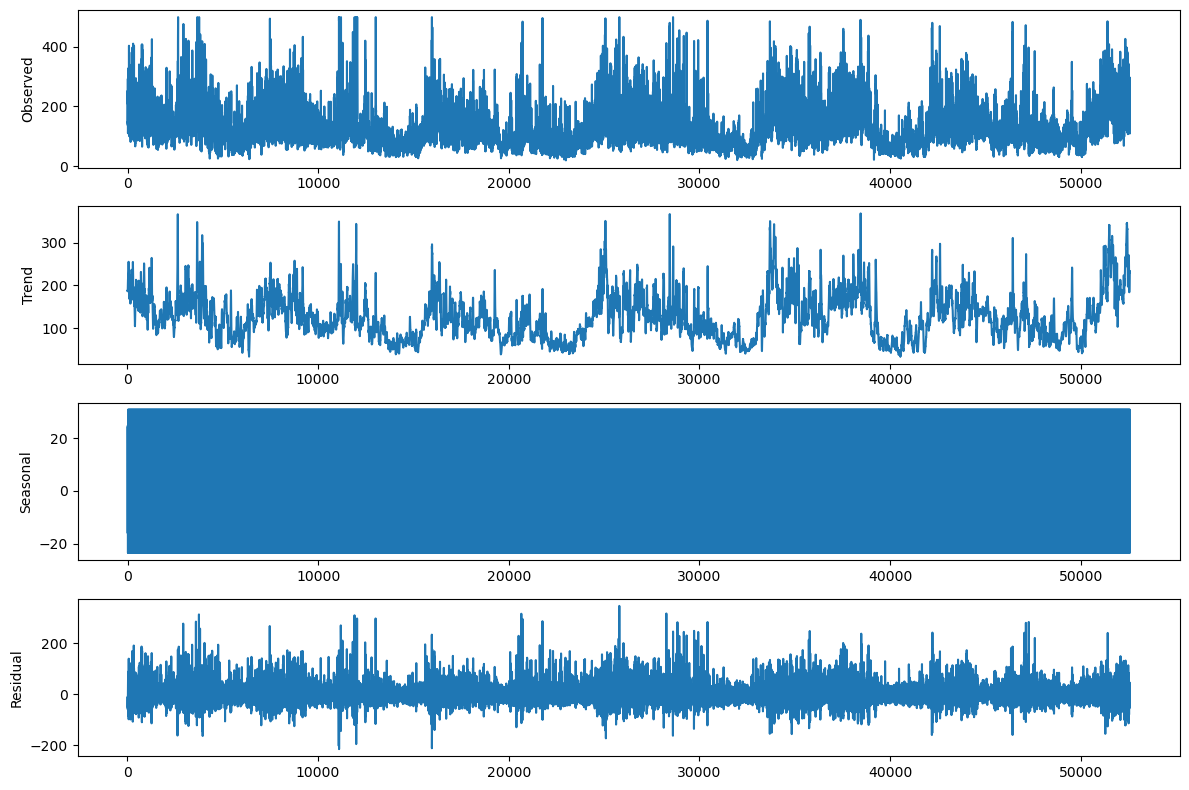

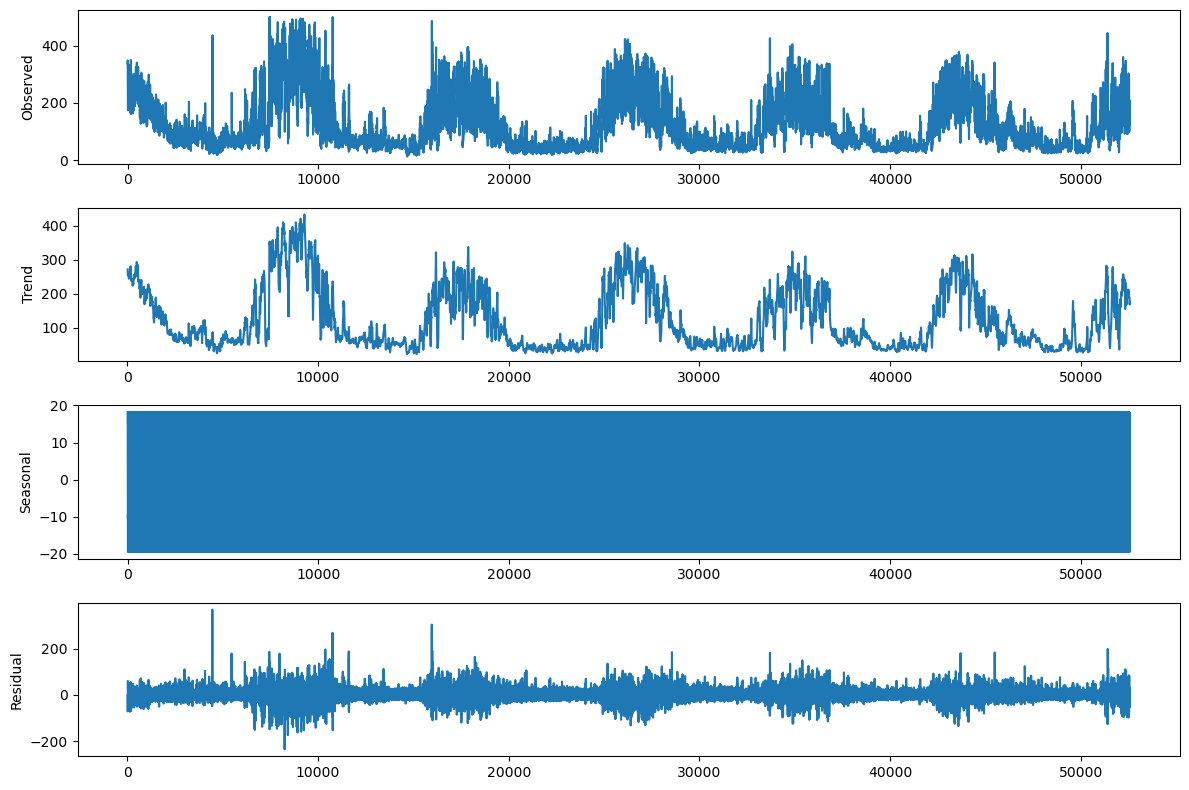

In [11]:
# Assume df has been preprocessed to a flat structure with hourly data
# Setting period to 24 for daily seasonality
results_jaipur = seasonal_decompose(df_jaipur_flattened, model='additive', period=24)
results_kolkata = seasonal_decompose(df_kolkata_flattened, model='additive', period=24)

# Plotting each component manually for Jaipur
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_jaipur.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_jaipur.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_jaipur.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_jaipur.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

# Plotting each component manually for Kolkata
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_kolkata.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_kolkata.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_kolkata.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_kolkata.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

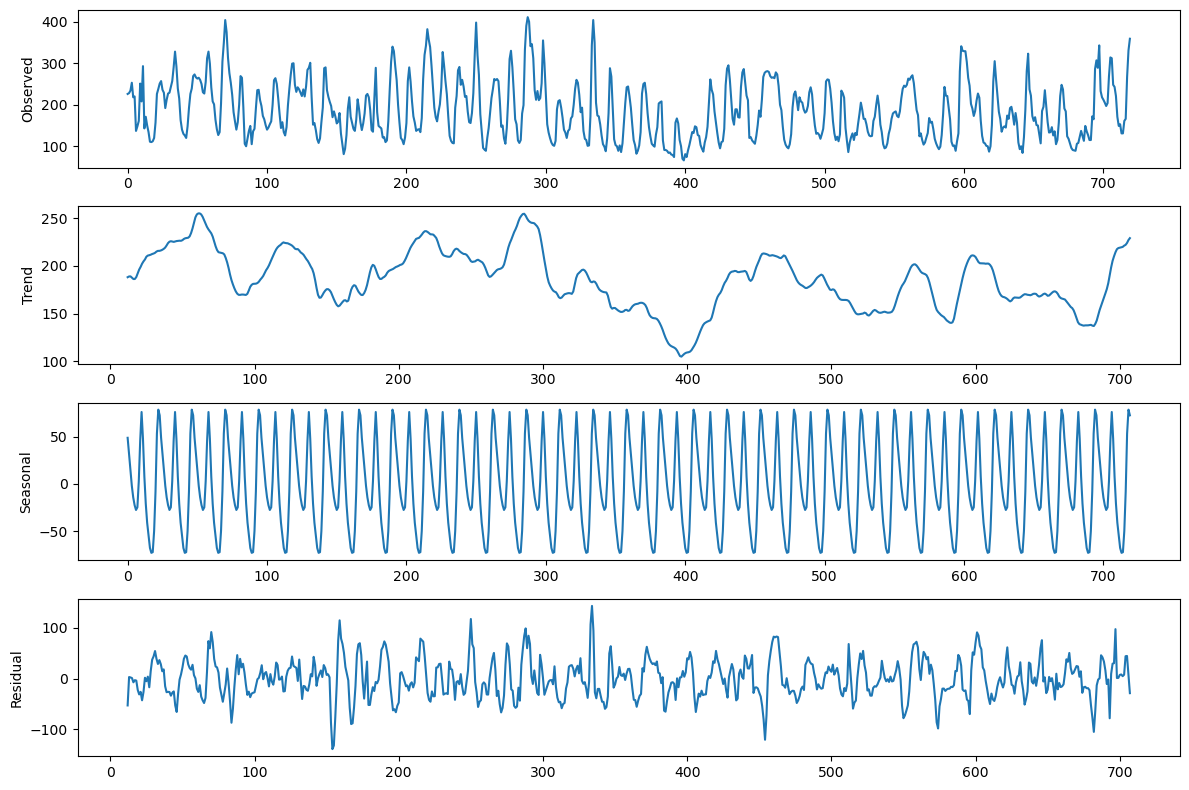

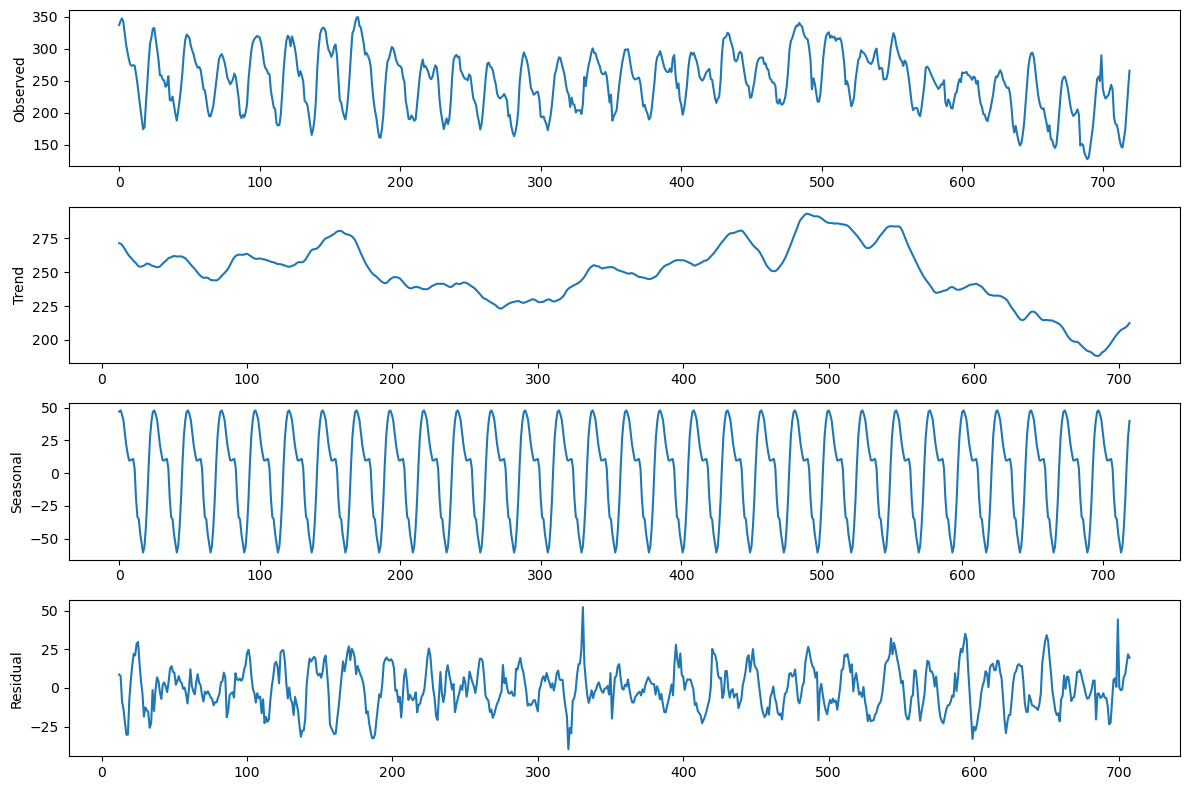

In [12]:
# Assume df has been preprocessed to a flat structure with hourly data
# Setting period to 24 for daily seasonality
results_jaipur = seasonal_decompose(df_jaipur_flattened.iloc[:24*30], model='additive', period=24)
results_kolkata = seasonal_decompose(df_kolkata_flattened.iloc[:24*30], model='additive', period=24)

# Plotting each component manually for Jaipur
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_jaipur.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_jaipur.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_jaipur.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_jaipur.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

# Plotting each component manually for Kolkata
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_kolkata.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_kolkata.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_kolkata.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_kolkata.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

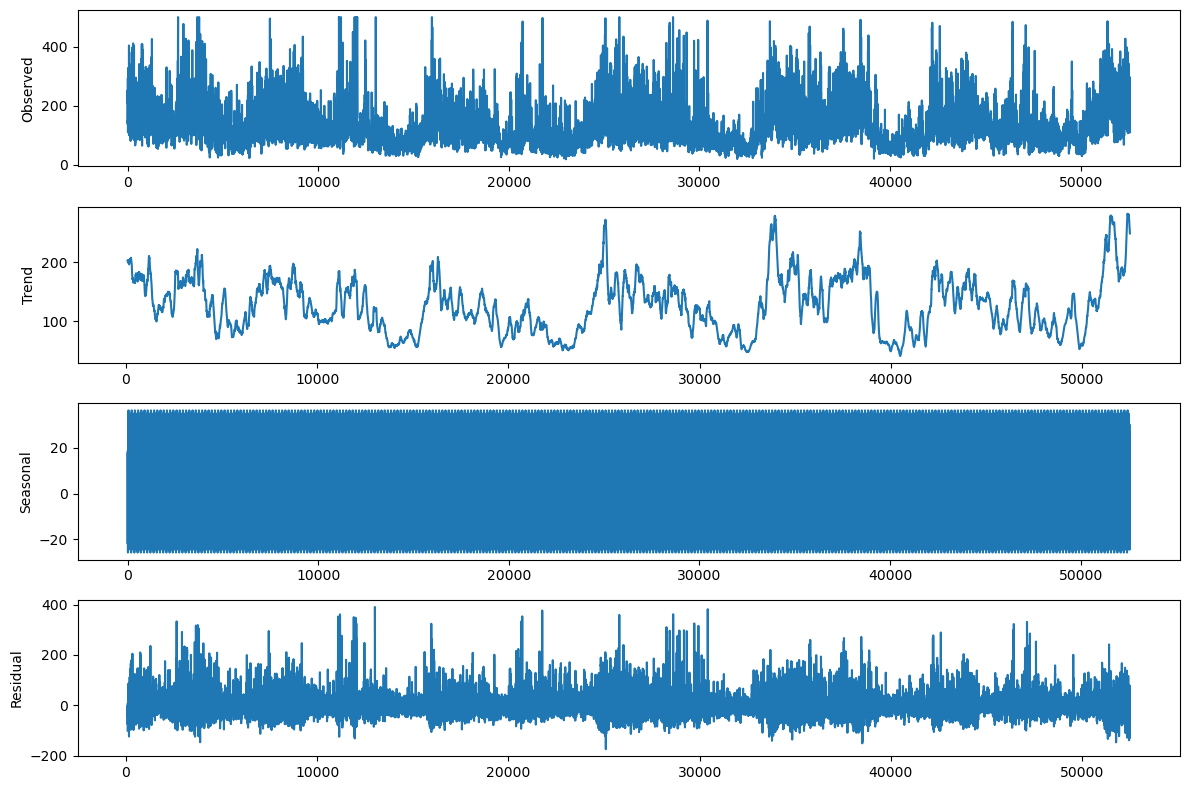

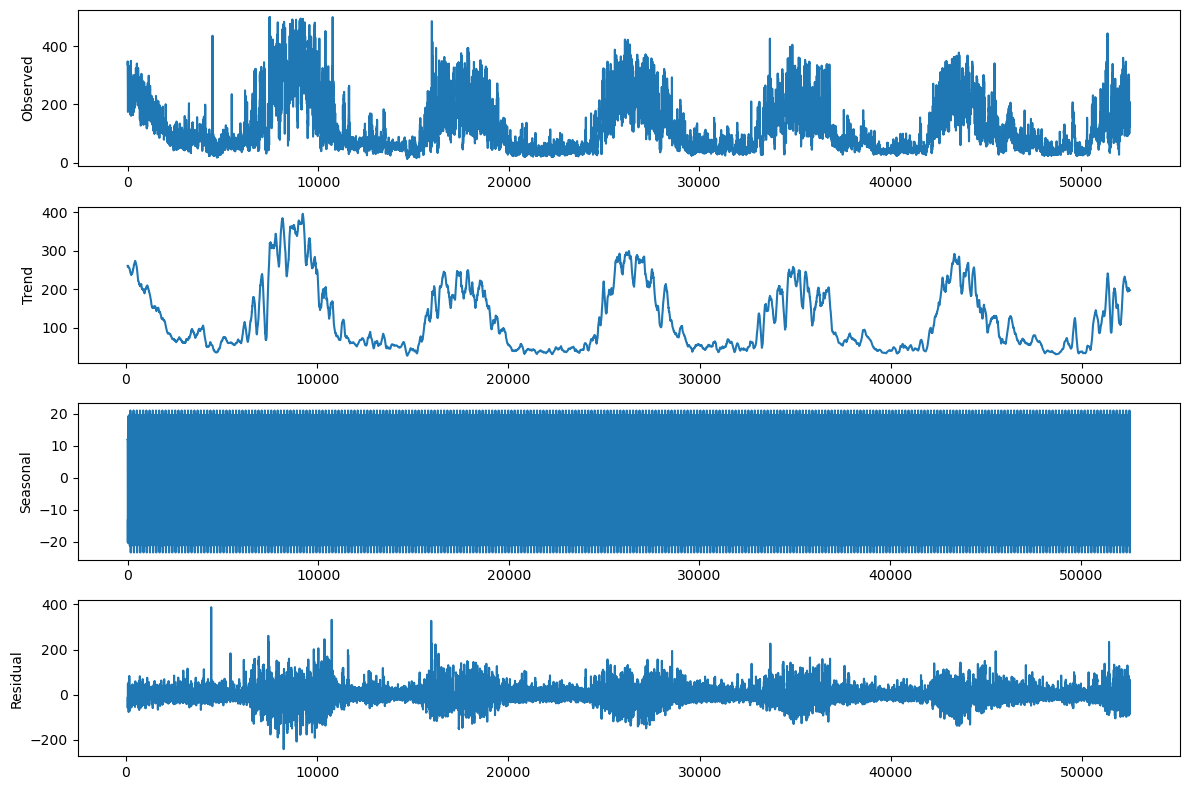

In [13]:
# Assume df has been preprocessed to a flat structure with hourly data
# Setting period to 24 for daily seasonality
results_jaipur = seasonal_decompose(df_jaipur_flattened, model='additive', period=(24*7))
results_kolkata = seasonal_decompose(df_kolkata_flattened, model='additive', period=(24*7))

# Plotting each component manually for Jaipur
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_jaipur.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_jaipur.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_jaipur.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_jaipur.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

# Plotting each component manually for Kolkata
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_kolkata.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_kolkata.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_kolkata.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_kolkata.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

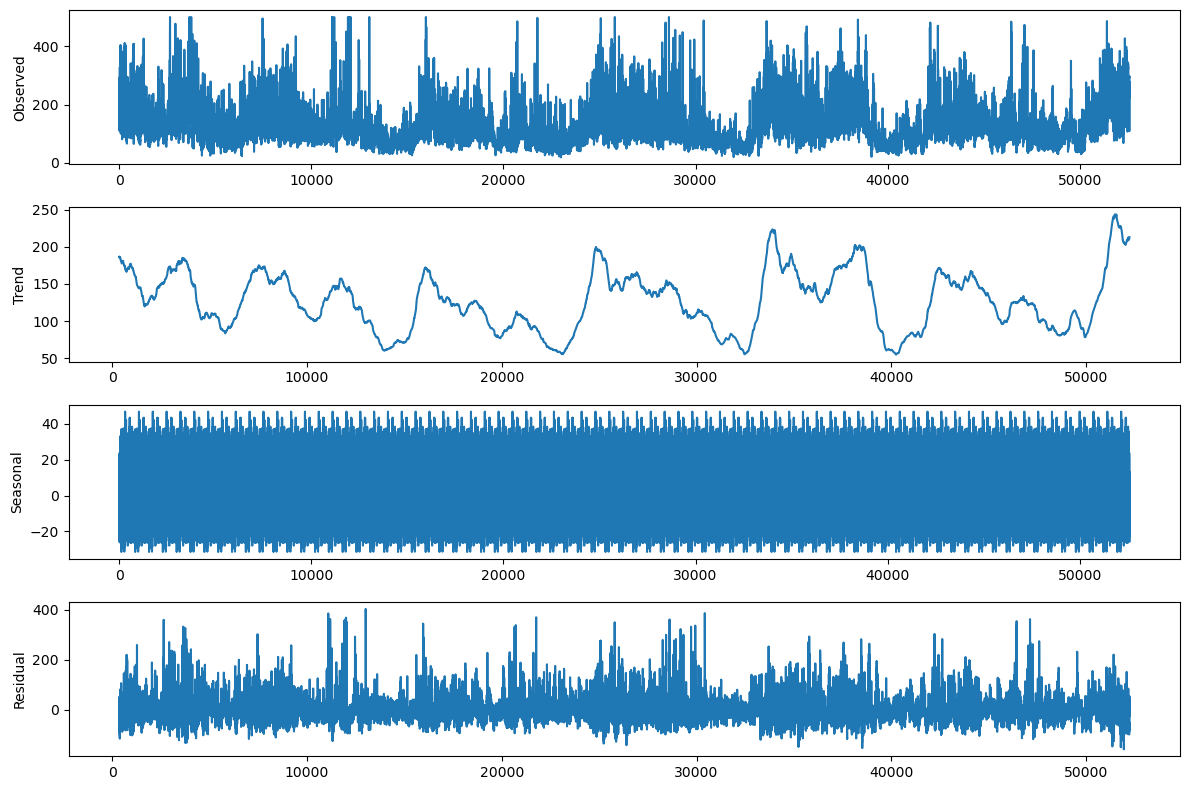

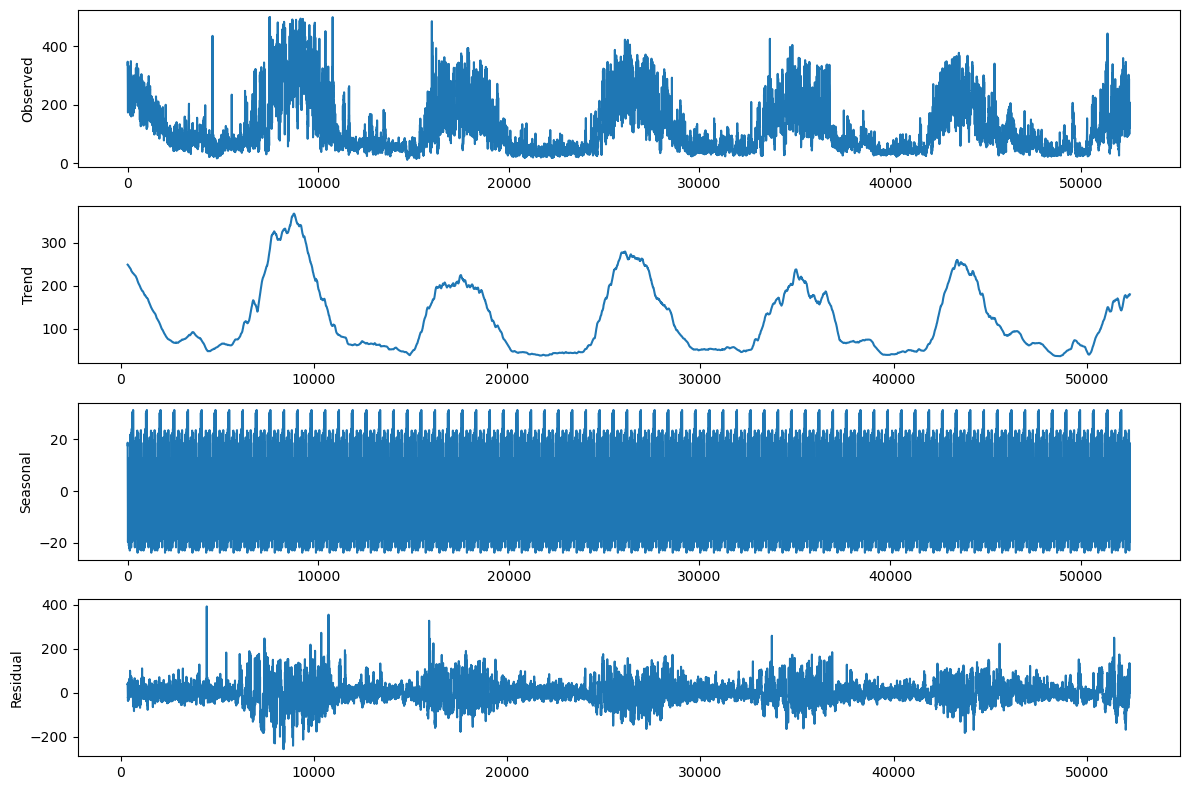

In [14]:
# Assume df has been preprocessed to a flat structure with hourly data
# Setting period to 24 for daily seasonality
results_jaipur = seasonal_decompose(df_jaipur_flattened, model='additive', period=(24*30))
results_kolkata = seasonal_decompose(df_kolkata_flattened, model='additive', period=(24*30))

# Plotting each component manually for Jaipur
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_jaipur.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_jaipur.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_jaipur.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_jaipur.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

# Plotting each component manually for Kolkata
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_kolkata.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_kolkata.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_kolkata.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_kolkata.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

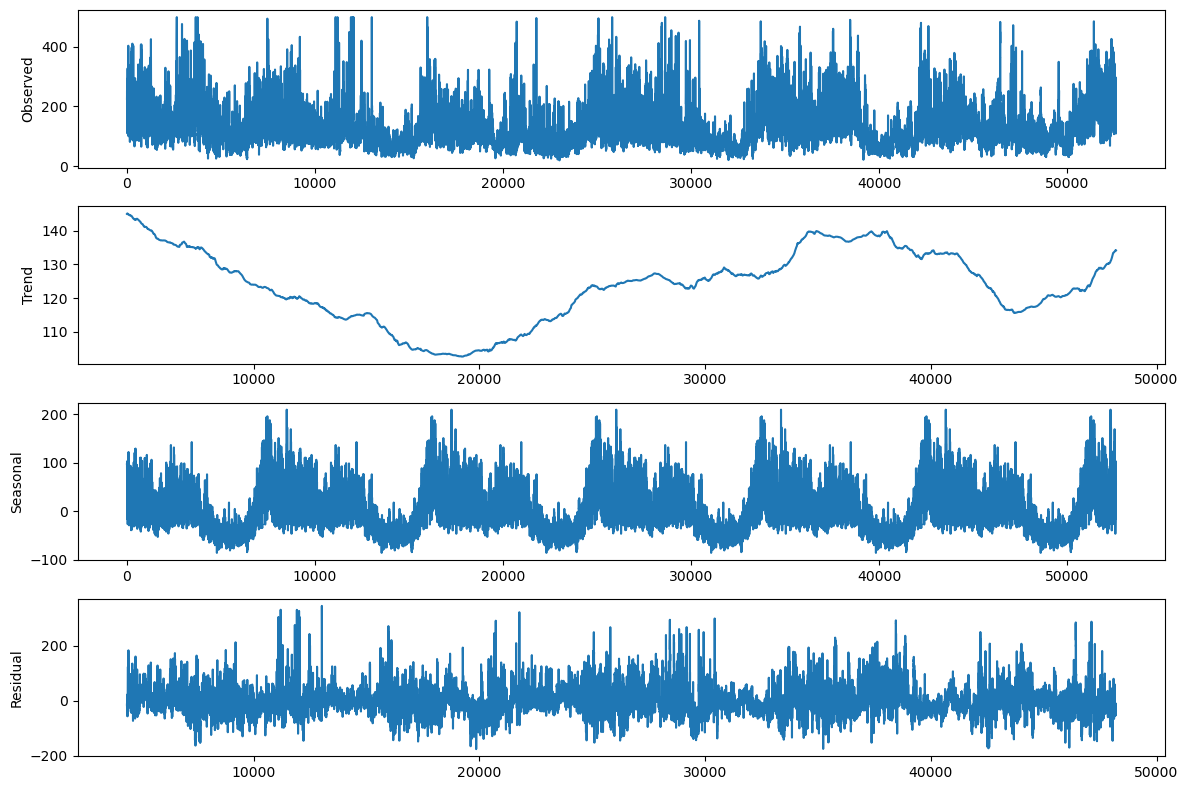

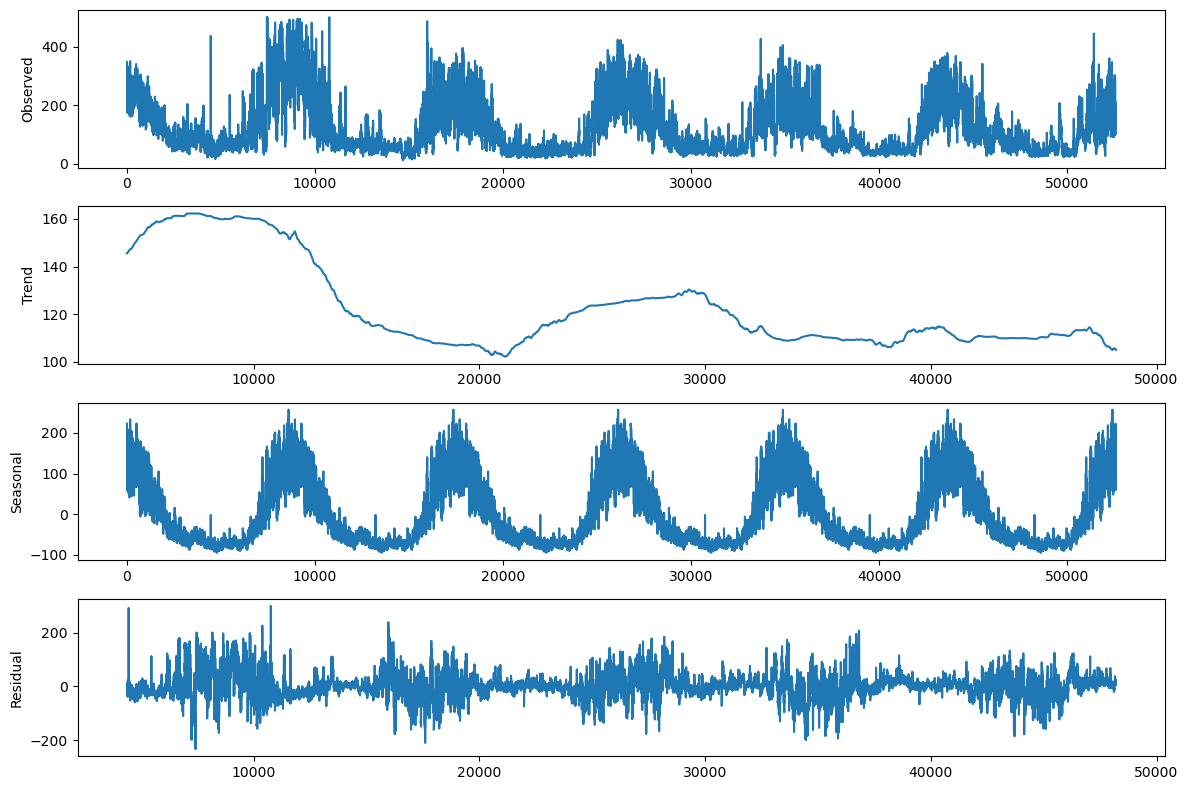

In [15]:
# Assume df has been preprocessed to a flat structure with hourly data
# Setting period to 24 for daily seasonality
results_jaipur = seasonal_decompose(df_jaipur_flattened, model='additive', period=(24*365))
results_kolkata = seasonal_decompose(df_kolkata_flattened, model='additive', period=(24*365))

# Plotting each component manually for Jaipur
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_jaipur.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_jaipur.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_jaipur.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_jaipur.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

# Plotting each component manually for Kolkata
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

results_kolkata.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

results_kolkata.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

results_kolkata.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

results_kolkata.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF Test
adf_result = adfuller(df_jaipur_flattened)
adf_statistic, adf_p_value = adf_result[0], adf_result[1]
print("ADF Statistic:", adf_statistic)
print("ADF p-value:", adf_p_value)
if adf_p_value < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

# Perform KPSS Test
kpss_result = kpss(df_jaipur_flattened, regression='c', nlags="auto")
kpss_statistic, kpss_p_value = kpss_result[0], kpss_result[1]
print("\nKPSS Statistic:", kpss_statistic)
print("KPSS p-value:", kpss_p_value)
if kpss_p_value < 0.05:
    print("Reject the null hypothesis: The series is non-stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

# Perform ADF Test
adf_result = adfuller(df_kolkata_flattened)
adf_statistic, adf_p_value = adf_result[0], adf_result[1]
print("ADF Statistic:", adf_statistic)
print("ADF p-value:", adf_p_value)
if adf_p_value < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

# Perform KPSS Test
kpss_result = kpss(df_kolkata_flattened, regression='c', nlags="auto")
kpss_statistic, kpss_p_value = kpss_result[0], kpss_result[1]
print("\nKPSS Statistic:", kpss_statistic)
print("KPSS p-value:", kpss_p_value)
if kpss_p_value < 0.05:
    print("Reject the null hypothesis: The series is non-stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

ADF Statistic: -11.718411059167801
ADF p-value: 1.4326859700530826e-21
Reject the null hypothesis: The series is stationary.

KPSS Statistic: 0.7193165175193232
KPSS p-value: 0.01178940749824334
Reject the null hypothesis: The series is non-stationary.
ADF Statistic: -7.485070214264995
ADF p-value: 4.66231754959477e-11
Reject the null hypothesis: The series is stationary.

KPSS Statistic: 1.278749771414931
KPSS p-value: 0.01
Reject the null hypothesis: The series is non-stationary.


C:\Users\ROG\AppData\Local\Temp\ipykernel_232\3478514933.py:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df_kolkata_flattened, regression='c', nlags="auto")


In [17]:
# Differencing the series (lag-1 differencing)
df_differenced = df_kolkata_flattened.diff().dropna()

# Recheck stationarity using ADF and KPSS tests
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
adf_result = adfuller(df_differenced)
print(f"ADF Statistic: {adf_result[0]}")
print(f"ADF p-value: {adf_result[1]}")
if adf_result[1] <= 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

# KPSS test
kpss_result = kpss(df_differenced, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"KPSS p-value: {kpss_result[1]}")
if kpss_result[1] <= 0.05:
    print("Reject the null hypothesis: The series is non-stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

    # Differencing the series (lag-1 differencing)
df_differenced = df_jaipur_flattened.diff().dropna()

# Recheck stationarity using ADF and KPSS tests
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
adf_result = adfuller(df_differenced)
print(f"ADF Statistic: {adf_result[0]}")
print(f"ADF p-value: {adf_result[1]}")
if adf_result[1] <= 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

# KPSS test
kpss_result = kpss(df_differenced, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"KPSS p-value: {kpss_result[1]}")
if kpss_result[1] <= 0.05:
    print("Reject the null hypothesis: The series is non-stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")
    

ADF Statistic: -37.917991871253285
ADF p-value: 0.0
Reject the null hypothesis: The series is stationary.
KPSS Statistic: 0.04411880761438895
KPSS p-value: 0.1
Fail to reject the null hypothesis: The series is stationary.


C:\Users\ROG\AppData\Local\Temp\ipykernel_232\3086375504.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_differenced, regression='c', nlags="auto")


ADF Statistic: -44.23689765654193
ADF p-value: 0.0
Reject the null hypothesis: The series is stationary.
KPSS Statistic: 0.04530191192332634
KPSS p-value: 0.1
Fail to reject the null hypothesis: The series is stationary.


C:\Users\ROG\AppData\Local\Temp\ipykernel_232\3086375504.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_differenced, regression='c', nlags="auto")


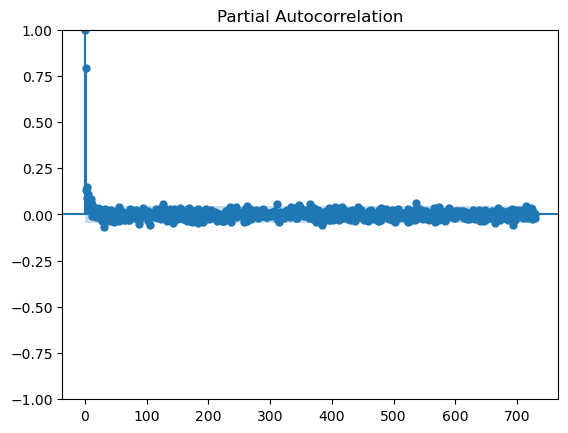

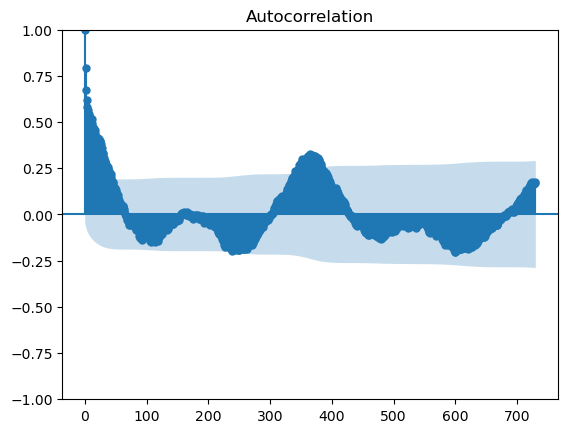

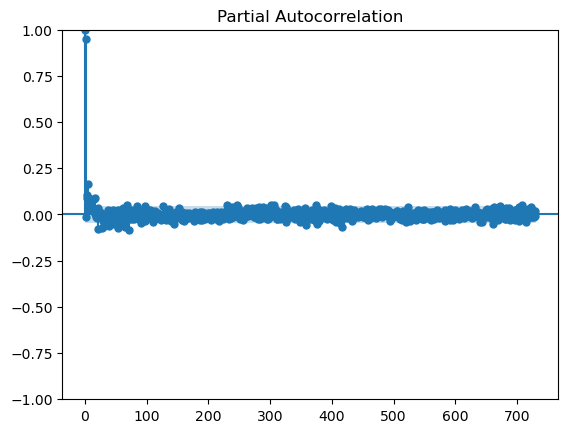

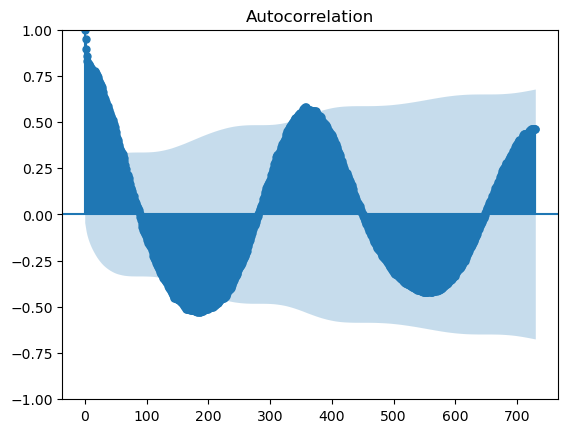

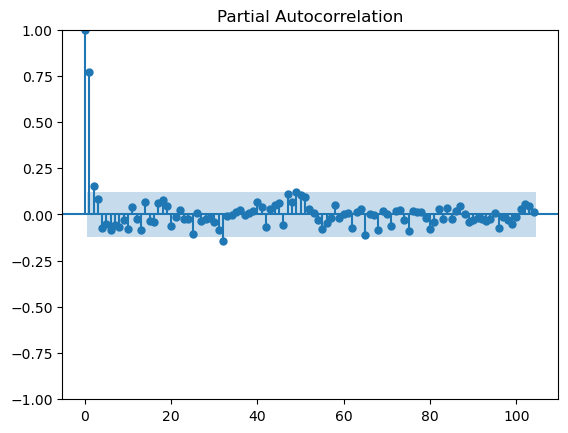

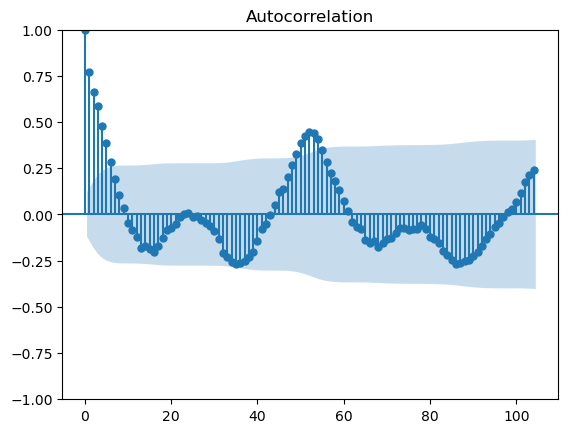

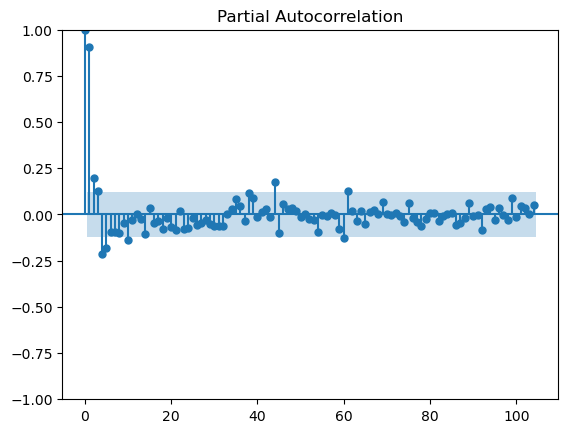

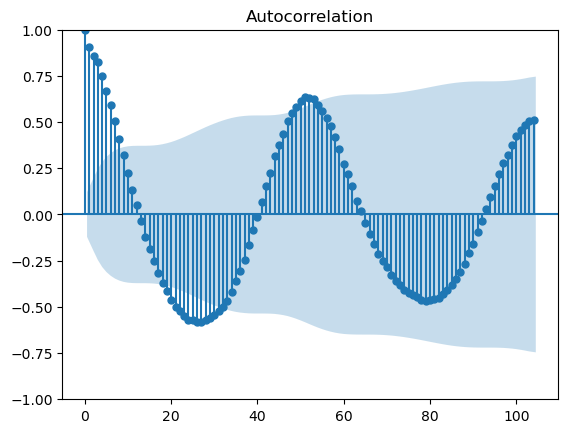

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

daily_jaipur_aqi = df_jaipur_flattened.values.reshape(-1, 24).mean(axis=1)
weekly_jaipur_aqi = df_jaipur_flattened.values.reshape(-1, (24*7)).mean(axis=1)

date_jaipur_range = pd.date_range(start='2018-01-01', periods=len(daily_jaipur_aqi), freq='D')
week_jaipur_range = pd.date_range(start='2018-01-01', periods=len(weekly_jaipur_aqi), freq='W')

daily_jaipur_df = pd.DataFrame({'Date': date_jaipur_range, 'Daily_AQI': daily_jaipur_aqi})
weekly_jaipur_df = pd.DataFrame({'Date': week_jaipur_range, 'Weekly_AQI': weekly_jaipur_aqi})

# Set Date as the index
daily_jaipur_df.set_index('Date', inplace=True)
weekly_jaipur_df.set_index('Date', inplace=True)

daily_kolkata_aqi = df_kolkata_flattened.values.reshape(-1, 24).mean(axis=1)
weekly_kolkata_aqi = df_kolkata_flattened.values.reshape(-1, (24*7)).mean(axis=1)

# Create a daily DataFrame (if you don't have a date column)
# We will create a date range from the start to the end of the 6 years.
date_kolkata_range = pd.date_range(start='2018-01-01', periods=len(daily_kolkata_aqi), freq='D')
week_kolkata_range = pd.date_range(start='2018-01-01', periods=len(weekly_kolkata_aqi), freq='W')

daily_kolkata_df = pd.DataFrame({'Date': date_kolkata_range, 'Daily_AQI': daily_kolkata_aqi})
weekly_kolkata_df = pd.DataFrame({'Date': week_kolkata_range, 'Weekly_AQI': weekly_kolkata_aqi})

# Set Date as the index
daily_kolkata_df.set_index('Date', inplace=True)
weekly_kolkata_df.set_index('Date', inplace=True)

# Split the data (train on all but the last 365 days)
train_data_jaipur = daily_jaipur_df.iloc[:-365]  # All data except the last 365 days
test_data_jaipur = daily_jaipur_df.iloc[-365:]   # Last 365 days for testing

pacf_jaipur = plot_pacf(train_data_jaipur['Daily_AQI'], lags=(365*2))
acf_jaipur = plot_acf(train_data_jaipur['Daily_AQI'], lags=(365*2))

# Split the data (train on all but the last 365 days)
train_data_kolkata = daily_kolkata_df.iloc[:-365]  # All data except the last 365 days
test_data_kolkata = daily_kolkata_df.iloc[-365:]   # Last 365 days for testing

pacf_kolkata = plot_pacf(train_data_kolkata['Daily_AQI'], lags=(365*2))
acf_kolkata = plot_acf(train_data_kolkata['Daily_AQI'], lags=(365*2))

# Split the data (train on all but the last 52 weeks)
train_data_jaipur_weekly = weekly_jaipur_df.iloc[:-52]  # All data except the last 52 weeks
test_data_jaipur_weekly = weekly_jaipur_df.iloc[-52:]   # Last 52 weeks for testing

pacf_jaipur_weekly = plot_pacf(train_data_jaipur_weekly['Weekly_AQI'], lags=(52*2))
acf_jaipur_weekly = plot_acf(train_data_jaipur_weekly['Weekly_AQI'], lags=(52*2))

# Split the data (train on all but the last 365 days)
train_data_kolkata = weekly_kolkata_df.iloc[:-52]  # All data except the last 365 days
test_data_kolkata = weekly_kolkata_df.iloc[-52:]   # Last 365 days for testing

pacf_kolkata = plot_pacf(train_data_kolkata['Weekly_AQI'], lags=(52*2))
acf_kolkata = plot_acf(train_data_kolkata['Weekly_AQI'], lags=(52*2))

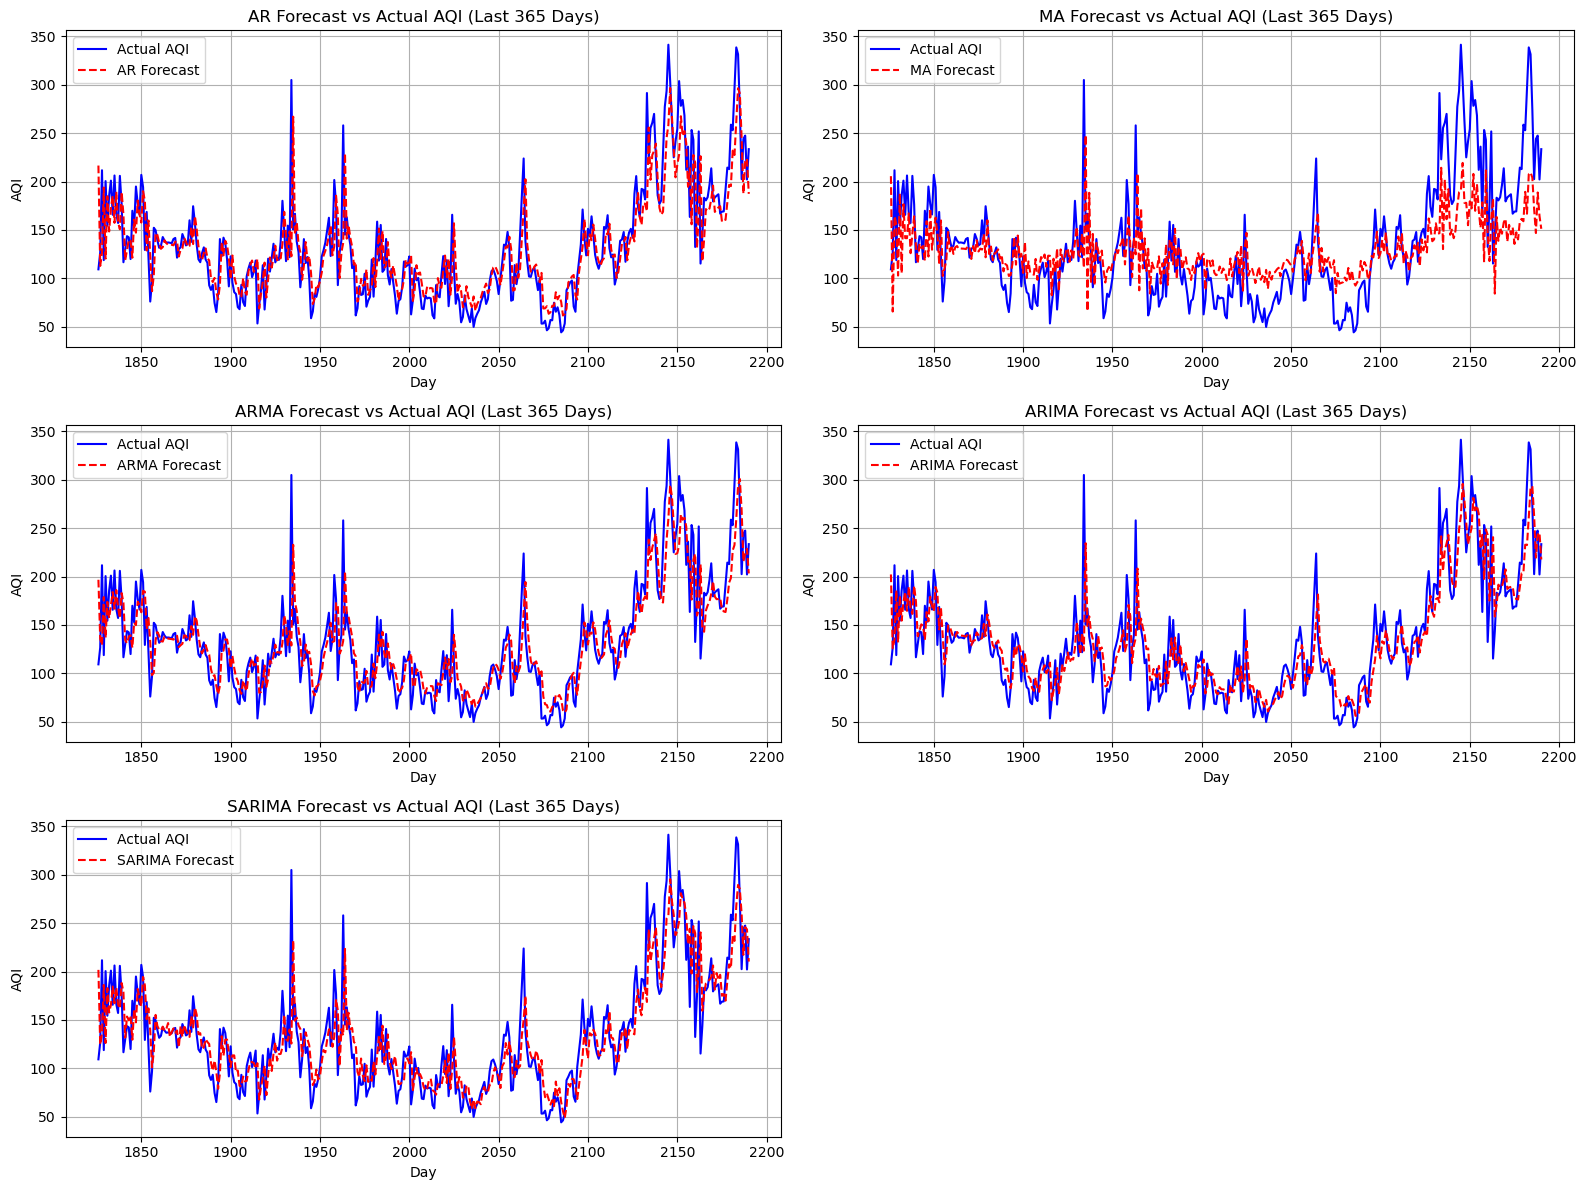

AR Model R2: 0.69
AR Model MAE: 22.92
AR Model RMSE: 32.65
MA Model R2: 0.44
MA Model MAE: 32.15
MA Model RMSE: 43.71
ARMA Model R2: 0.72
ARMA Model MAE: 22.01
ARMA Model RMSE: 31.10
ARIMA Model R2: 0.72
ARIMA Model MAE: 21.64
ARIMA Model RMSE: 31.06
SARIMA Model R2: 0.72
SARIMA Model MAE: 21.88
SARIMA Model RMSE: 31.28


In [19]:
# Assuming `daily_df` contains the flattened AQI data as a single column
# Ensure the data is daily aggregated
data = daily_jaipur_df['Daily_AQI'].values

# Split data into training and testing
train_data = data[:-365]  # All except the last 365 days
test_data = data[-365:]   # Last 365 days for validation

# Initialize dictionaries to store forecasts
forecasts = {
    'AR': [],
    'MA': [],
    'ARMA': [],
    'ARIMA': [],
    'SARIMA': []
}

# Function to train, forecast, and append results dynamically
def train_and_forecast(model_type, train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=1, seasonal_period=30):
    model_forecast = []
    for i in range(len(test_data)):
        if model_type == 'AR':
            model = ARIMA(train_data, order=(p, 0, 0))  # AR model
        elif model_type == 'MA':
            model = ARIMA(train_data, order=(0, 0, q))  # MA model
        elif model_type == 'ARMA':
            model = ARIMA(train_data, order=(p, 0, q))  # ARMA model
        elif model_type == 'ARIMA':
            model = ARIMA(train_data, order=(p, d, q))  # ARIMA model
        elif model_type == 'SARIMA':
            model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))  # SARIMA model
        
        # Fit the model
        model_fitted = model.fit()
        
        # Forecast the next day
        forecast = model_fitted.forecast(steps=1)
        model_forecast.append(forecast[0])
        
        # Update training data with the actual value
        train_data = list(train_data) + [test_data[i]]
    
    return model_forecast

# Train and forecast for each model type
forecasts['AR'] = train_and_forecast('AR', train_data, test_data, p=1)
forecasts['MA'] = train_and_forecast('MA', train_data, test_data, q=1)
forecasts['ARMA'] = train_and_forecast('ARMA', train_data, test_data, p=1, q=1)
forecasts['ARIMA'] = train_and_forecast('ARIMA', train_data, test_data, p=1, d=1, q=1)
forecasts['SARIMA'] = train_and_forecast('SARIMA', train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=1, seasonal_period=30)

# Convert test data and forecasts to pandas series for easier plotting
test_series = pd.Series(test_data, index=range(len(train_data), len(train_data) + len(test_data)))

# Plot forecasts vs actual for each model
plt.figure(figsize=(16, 12))
for i, (model_name, forecast) in enumerate(forecasts.items()):
    plt.subplot(3, 2, i + 1)
    forecast_series = pd.Series(forecast, index=test_series.index)
    plt.plot(test_series, label="Actual AQI", color="blue")
    plt.plot(forecast_series, label=f"{model_name} Forecast", color="red", linestyle="--")
    plt.title(f"{model_name} Forecast vs Actual AQI (Last 365 Days)")
    plt.xlabel("Day")
    plt.ylabel("AQI")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

for model_name, forecast in forecasts.items():
    r2 = r2_score(test_series, forecast)
    mae = mean_absolute_error(test_series, forecast)
    rmse = np.sqrt(mean_squared_error(test_series, forecast))
    print(f"{model_name} Model R2: {r2:.2f}")
    print(f"{model_name} Model MAE: {mae:.2f}")
    print(f"{model_name} Model RMSE: {rmse:.2f}")


c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


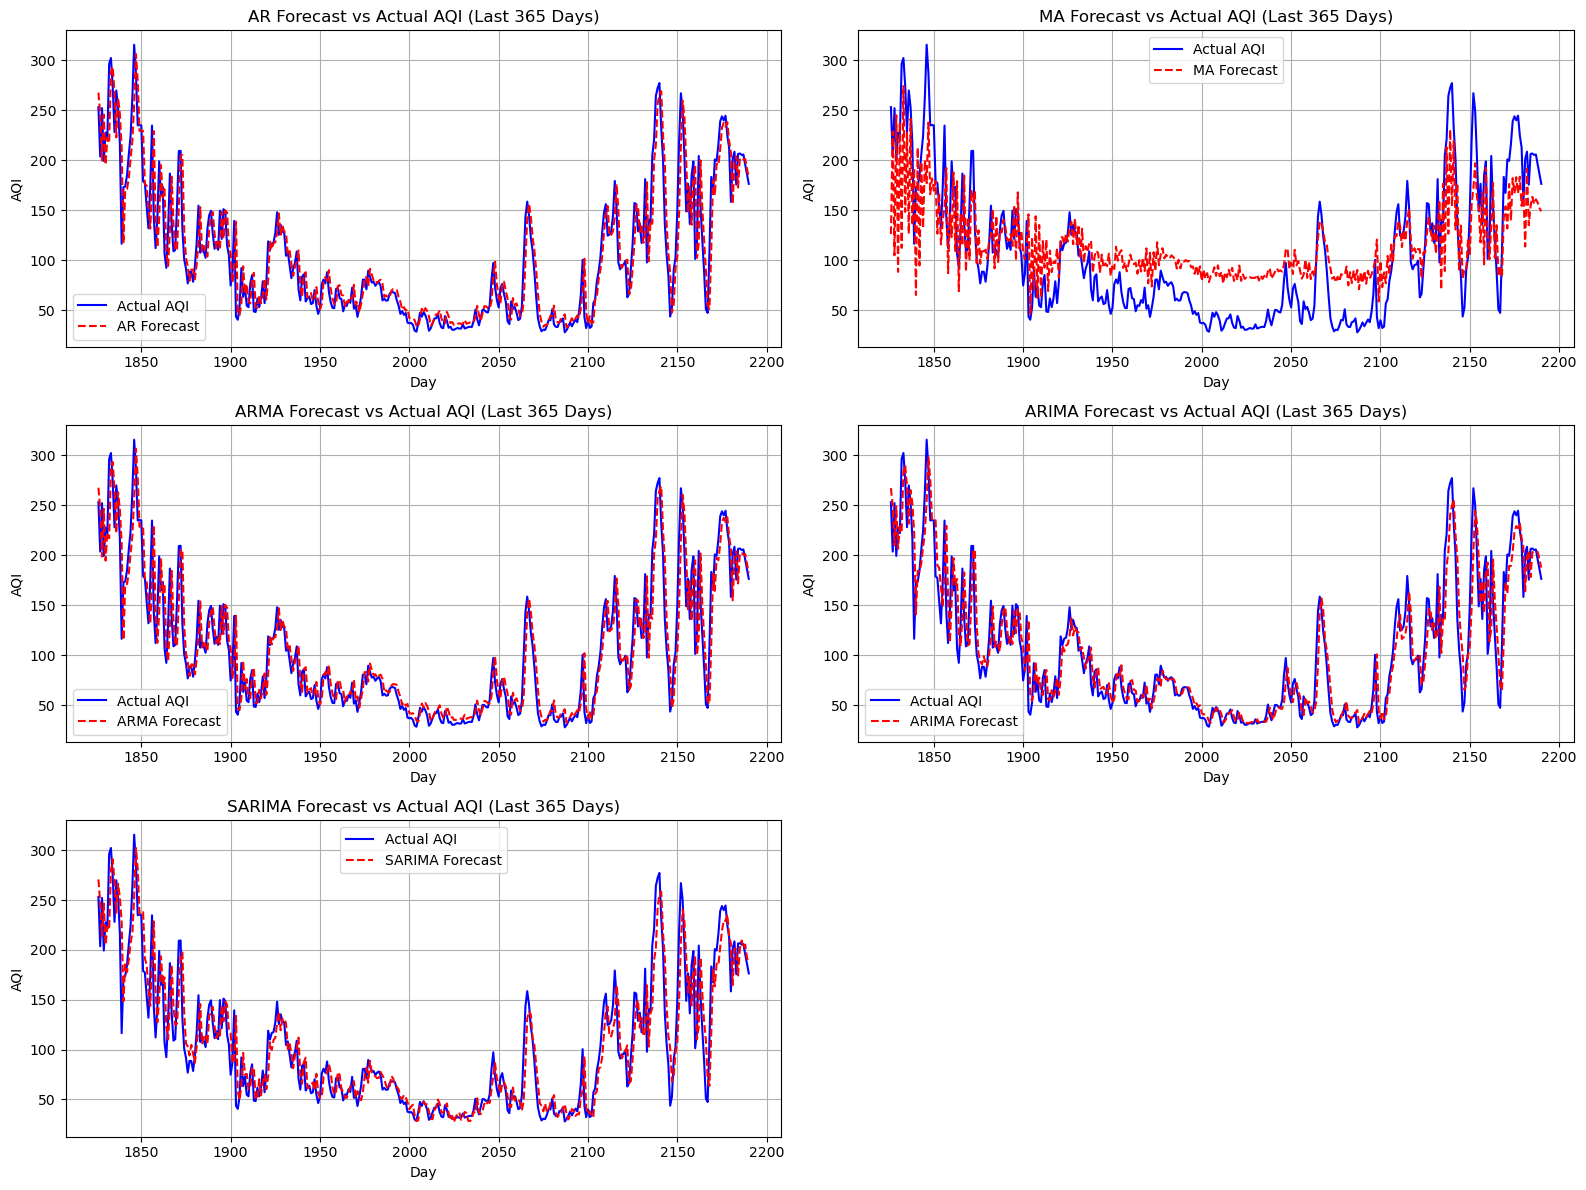

AR Model R2: 0.85
AR Model MAE: 18.12
AR Model RMSE: 26.18
MA Model R2: 0.52
MA Model MAE: 38.59
MA Model RMSE: 46.78
ARMA Model R2: 0.85
ARMA Model MAE: 18.10
ARMA Model RMSE: 26.17
ARIMA Model R2: 0.85
ARIMA Model MAE: 17.75
ARIMA Model RMSE: 25.90
SARIMA Model R2: 0.85
SARIMA Model MAE: 18.21
SARIMA Model RMSE: 25.95


In [20]:
# Assuming `daily_df` contains the flattened AQI data as a single column
# Ensure the data is daily aggregated
data = daily_kolkata_df['Daily_AQI'].values

# Split data into training and testing
train_data = data[:-365]  # All except the last 365 days
test_data = data[-365:]   # Last 365 days for validation

# Initialize dictionaries to store forecasts
forecasts = {
    'AR': [],
    'MA': [],
    'ARMA': [],
    'ARIMA': [],
    'SARIMA': []
}

# Function to train, forecast, and append results dynamically
def train_and_forecast(model_type, train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=1, seasonal_period=30):
    model_forecast = []
    for i in range(len(test_data)):
        if model_type == 'AR':
            model = ARIMA(train_data, order=(p, 0, 0))  # AR model
        elif model_type == 'MA':
            model = ARIMA(train_data, order=(0, 0, q))  # MA model
        elif model_type == 'ARMA':
            model = ARIMA(train_data, order=(p, 0, q))  # ARMA model
        elif model_type == 'ARIMA':
            model = ARIMA(train_data, order=(p, d, q))  # ARIMA model
        elif model_type == 'SARIMA':
            model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))  # SARIMA model
        
        # Fit the model
        model_fitted = model.fit()
        
        # Forecast the next day
        forecast = model_fitted.forecast(steps=1)
        model_forecast.append(forecast[0])
        
        # Update training data with the actual value
        train_data = list(train_data) + [test_data[i]]
    
    return model_forecast

# Train and forecast for each model type
forecasts['AR'] = train_and_forecast('AR', train_data, test_data, p=1)
forecasts['MA'] = train_and_forecast('MA', train_data, test_data, q=1)
forecasts['ARMA'] = train_and_forecast('ARMA', train_data, test_data, p=1, q=1)
forecasts['ARIMA'] = train_and_forecast('ARIMA', train_data, test_data, p=1, d=1, q=1)
forecasts['SARIMA'] = train_and_forecast('SARIMA', train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=1, seasonal_period=30)

# Convert test data and forecasts to pandas series for easier plotting
test_series = pd.Series(test_data, index=range(len(train_data), len(train_data) + len(test_data)))

# Plot forecasts vs actual for each model
plt.figure(figsize=(16, 12))
for i, (model_name, forecast) in enumerate(forecasts.items()):
    plt.subplot(3, 2, i + 1)
    forecast_series = pd.Series(forecast, index=test_series.index)
    plt.plot(test_series, label="Actual AQI", color="blue")
    plt.plot(forecast_series, label=f"{model_name} Forecast", color="red", linestyle="--")
    plt.title(f"{model_name} Forecast vs Actual AQI (Last 365 Days)")
    plt.xlabel("Day")
    plt.ylabel("AQI")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

for model_name, forecast in forecasts.items():
    r2 = r2_score(test_series, forecast)
    mae = mean_absolute_error(test_series, forecast)
    rmse = np.sqrt(mean_squared_error(test_series, forecast))
    print(f"{model_name} Model R2: {r2:.2f}")
    print(f"{model_name} Model MAE: {mae:.2f}")
    print(f"{model_name} Model RMSE: {rmse:.2f}")


c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels

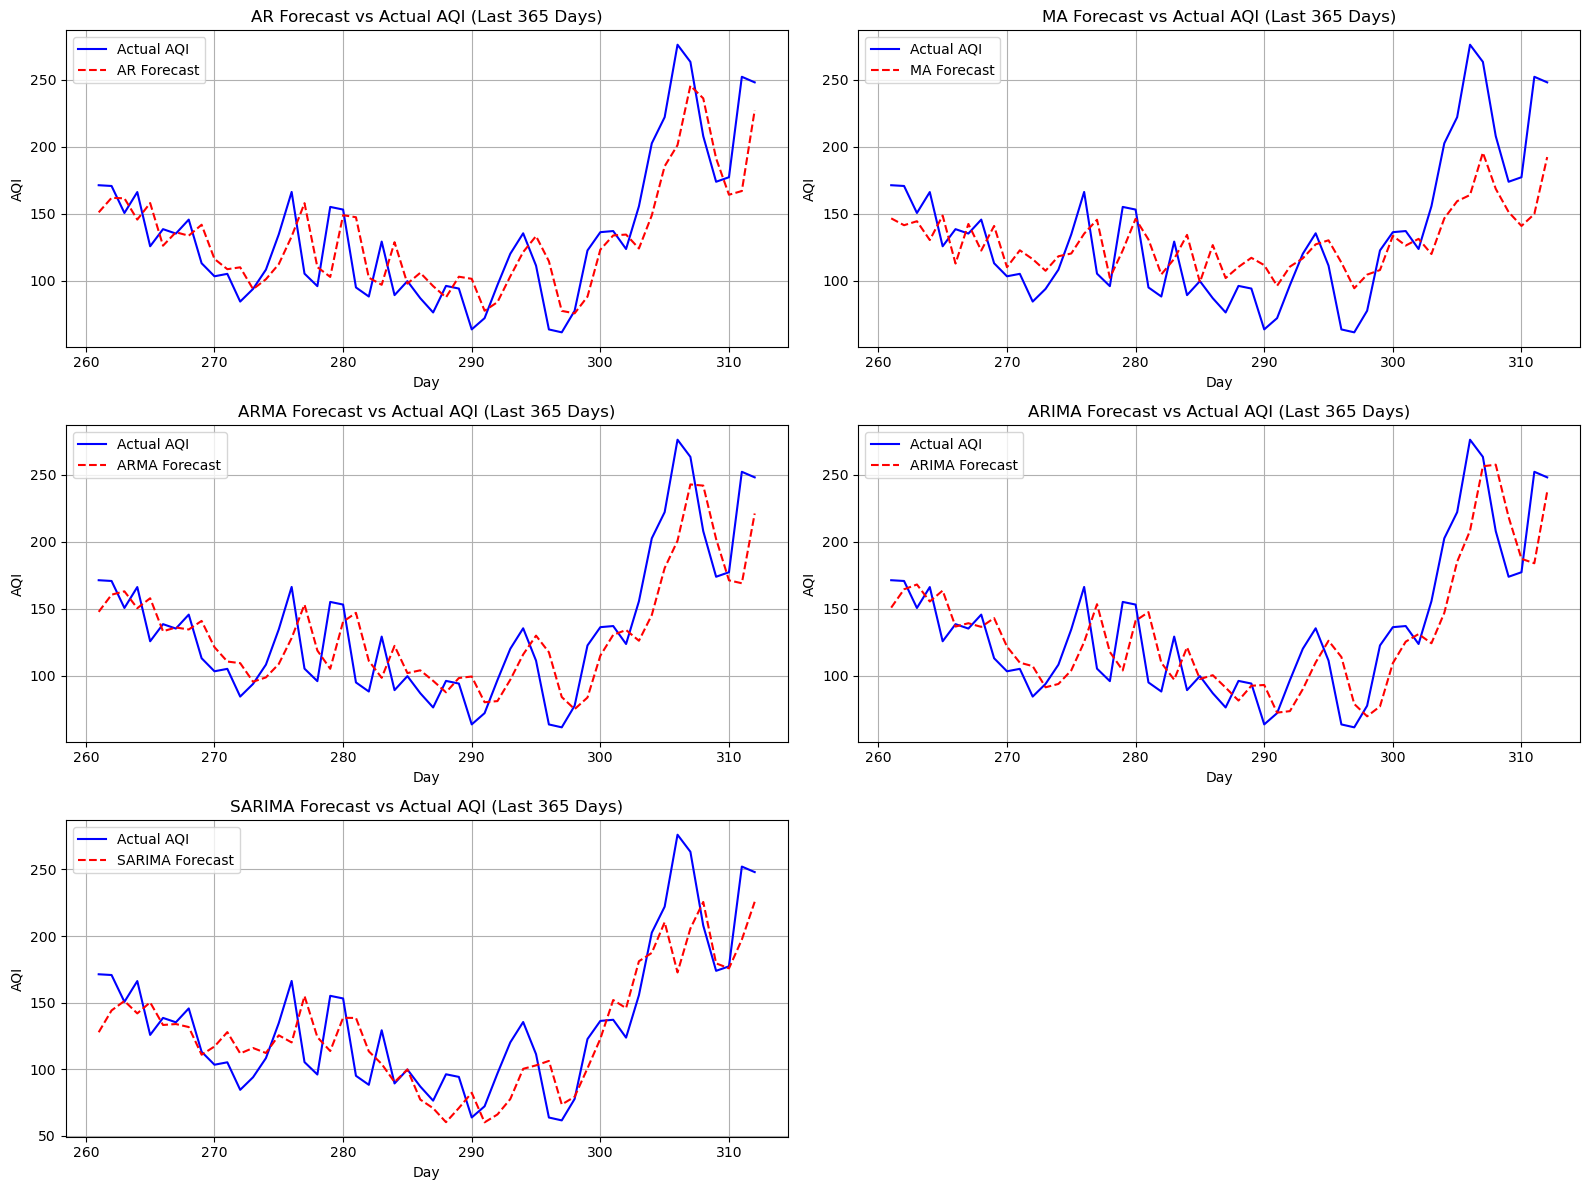

AR Model R2: 0.68
AR Model MAE: 22.87
AR Model RMSE: 29.37
MA Model R2: 0.52
MA Model MAE: 28.45
MA Model RMSE: 36.23
ARMA Model R2: 0.66
ARMA Model MAE: 24.35
ARMA Model RMSE: 30.29
ARIMA Model R2: 0.67
ARIMA Model MAE: 24.28
ARIMA Model RMSE: 30.05
SARIMA Model R2: 0.68
SARIMA Model MAE: 22.74
SARIMA Model RMSE: 29.52


In [21]:


# Assuming `daily_df` contains the flattened AQI data as a single column
# Ensure the data is daily aggregated
data = weekly_jaipur_df['Weekly_AQI'].values

# Split data into training and testing
train_data = data[:-52]  # All except the last 365 days
test_data = data[-52:]   # Last 365 days for validation

# Initialize dictionaries to store forecasts
forecasts = {
    'AR': [],
    'MA': [],
    'ARMA': [],
    'ARIMA': [],
    'SARIMA': []
}

# Function to train, forecast, and append results dynamically
def train_and_forecast(model_type, train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=1, seasonal_period=52):
    model_forecast = []
    for i in range(len(test_data)):
        if model_type == 'AR':
            model = ARIMA(train_data, order=(p, 0, 0))  # AR model
        elif model_type == 'MA':
            model = ARIMA(train_data, order=(0, 0, q))  # MA model
        elif model_type == 'ARMA':
            model = ARIMA(train_data, order=(p, 0, q))  # ARMA model
        elif model_type == 'ARIMA':
            model = ARIMA(train_data, order=(p, d, q))  # ARIMA model
        elif model_type == 'SARIMA':
            model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))  # SARIMA model
        
        # Fit the model
        model_fitted = model.fit()
        
        # Forecast the next day
        forecast = model_fitted.forecast(steps=1)
        model_forecast.append(forecast[0])
        
        # Update training data with the actual value
        train_data = list(train_data) + [test_data[i]]
    
    return model_forecast

# Train and forecast for each model type
forecasts['AR'] = train_and_forecast('AR', train_data, test_data, p=1)
forecasts['MA'] = train_and_forecast('MA', train_data, test_data, q=1)
forecasts['ARMA'] = train_and_forecast('ARMA', train_data, test_data, p=1, q=1)
forecasts['ARIMA'] = train_and_forecast('ARIMA', train_data, test_data, p=1, d=1, q=1)
forecasts['SARIMA'] = train_and_forecast('SARIMA', train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=1, seasonal_period=52)

# Convert test data and forecasts to pandas series for easier plotting
test_series = pd.Series(test_data, index=range(len(train_data), len(train_data) + len(test_data)))

# Plot forecasts vs actual for each model
plt.figure(figsize=(16, 12))
for i, (model_name, forecast) in enumerate(forecasts.items()):
    plt.subplot(3, 2, i + 1)
    forecast_series = pd.Series(forecast, index=test_series.index)
    plt.plot(test_series, label="Actual AQI", color="blue")
    plt.plot(forecast_series, label=f"{model_name} Forecast", color="red", linestyle="--")
    plt.title(f"{model_name} Forecast vs Actual AQI (Last 365 Days)")
    plt.xlabel("Day")
    plt.ylabel("AQI")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

for model_name, forecast in forecasts.items():
    r2 = r2_score(test_series, forecast)
    mae = mean_absolute_error(test_series, forecast)
    rmse = np.sqrt(mean_squared_error(test_series, forecast))
    print(f"{model_name} Model R2: {r2:.2f}")
    print(f"{model_name} Model MAE: {mae:.2f}")
    print(f"{model_name} Model RMSE: {rmse:.2f}")

c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ROG\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


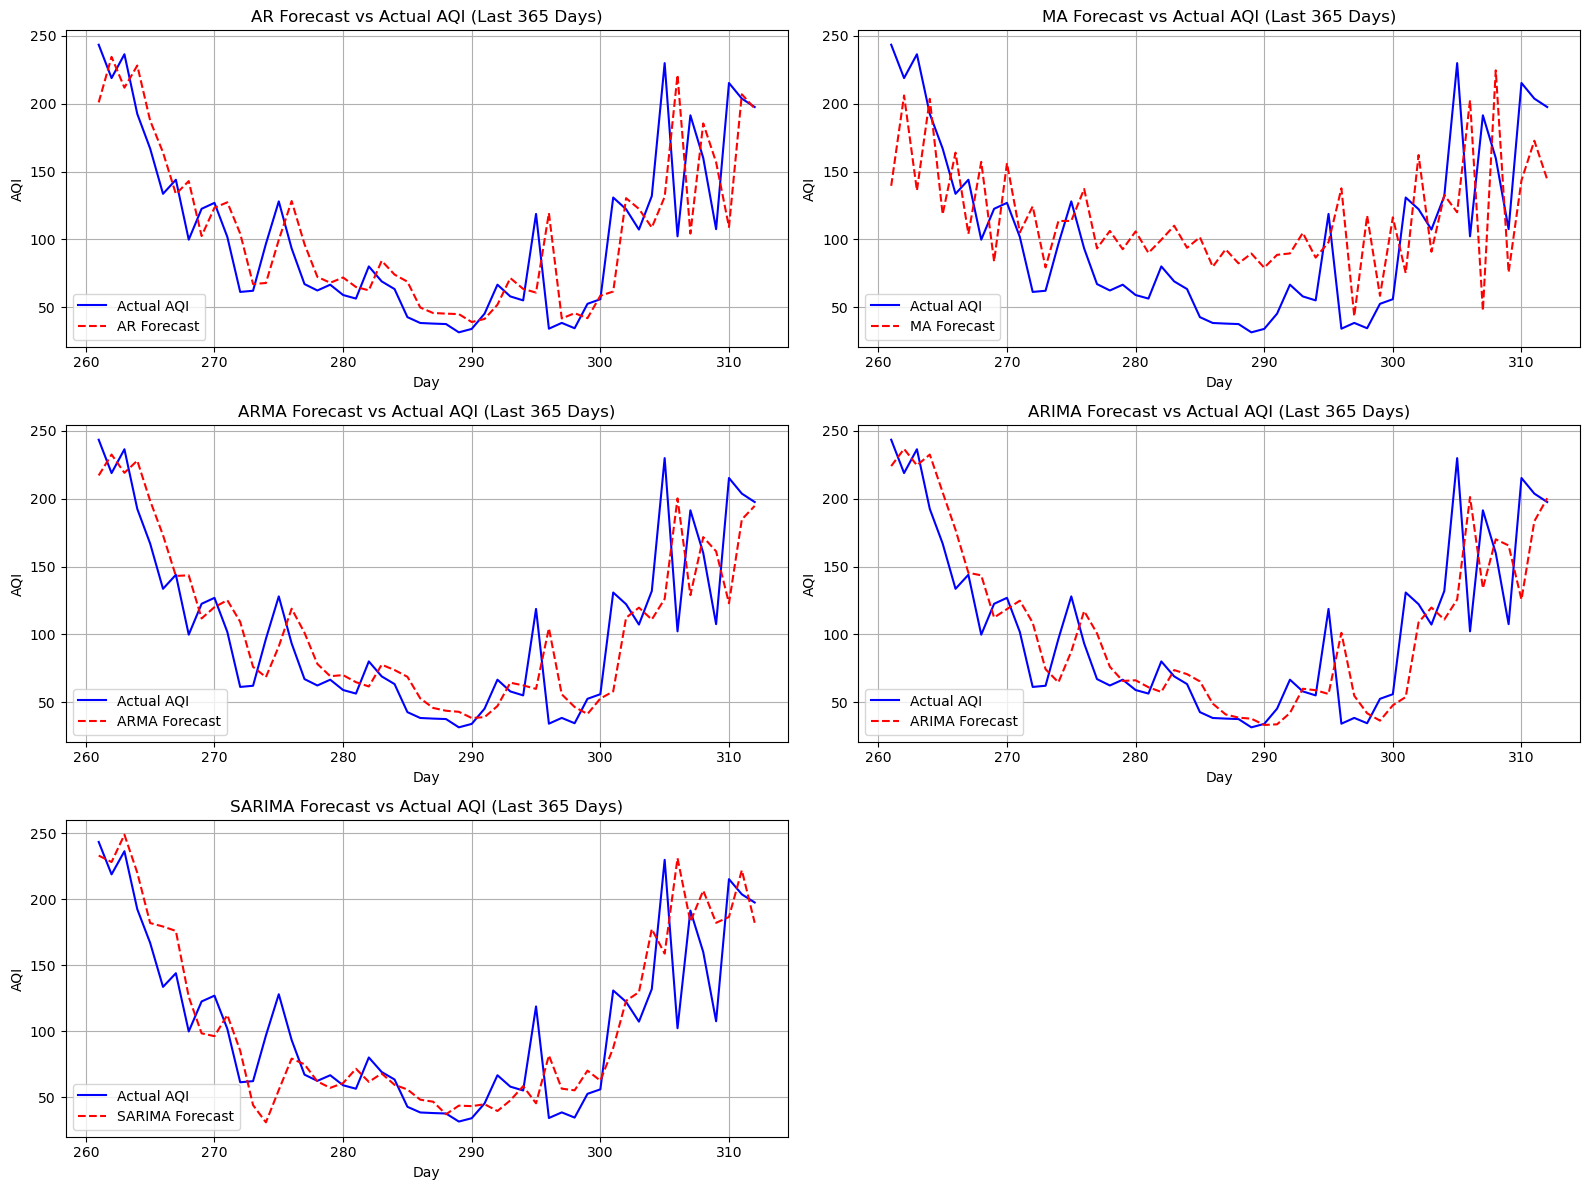

AR Model R2: 0.60
AR Model MAE: 27.05
AR Model RMSE: 38.93
MA Model R2: 0.22
MA Model MAE: 45.07
MA Model RMSE: 54.21
ARMA Model R2: 0.66
ARMA Model MAE: 26.04
ARMA Model RMSE: 36.13
ARIMA Model R2: 0.65
ARIMA Model MAE: 25.71
ARIMA Model RMSE: 36.43
SARIMA Model R2: 0.68
SARIMA Model MAE: 24.61
SARIMA Model RMSE: 35.01


In [22]:
# Assuming `daily_df` contains the flattened AQI data as a single column
# Ensure the data is daily aggregated
data = weekly_kolkata_df['Weekly_AQI'].values

# Split data into training and testing
train_data = data[:-52]  # All except the last 365 days
test_data = data[-52:]   # Last 365 days for validation

# Initialize dictionaries to store forecasts
forecasts = {
    'AR': [],
    'MA': [],
    'ARMA': [],
    'ARIMA': [],
    'SARIMA': []
}

# Function to train, forecast, and append results dynamically
def train_and_forecast(model_type, train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=1, seasonal_period=52):
    model_forecast = []
    for i in range(len(test_data)):
        if model_type == 'AR':
            model = ARIMA(train_data, order=(p, 0, 0))  # AR model
        elif model_type == 'MA':
            model = ARIMA(train_data, order=(0, 0, q))  # MA model
        elif model_type == 'ARMA':
            model = ARIMA(train_data, order=(p, 0, q))  # ARMA model
        elif model_type == 'ARIMA':
            model = ARIMA(train_data, order=(p, d, q))  # ARIMA model
        elif model_type == 'SARIMA':
            model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))  # SARIMA model
        
        # Fit the model
        model_fitted = model.fit()
        
        # Forecast the next day
        forecast = model_fitted.forecast(steps=1)
        model_forecast.append(forecast[0])
        
        # Update training data with the actual value
        train_data = list(train_data) + [test_data[i]]
    
    return model_forecast

# Train and forecast for each model type
forecasts['AR'] = train_and_forecast('AR', train_data, test_data, p=1)
forecasts['MA'] = train_and_forecast('MA', train_data, test_data, q=1)
forecasts['ARMA'] = train_and_forecast('ARMA', train_data, test_data, p=1, q=1)
forecasts['ARIMA'] = train_and_forecast('ARIMA', train_data, test_data, p=1, d=1, q=1)
forecasts['SARIMA'] = train_and_forecast('SARIMA', train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=1, seasonal_period=52)

# Convert test data and forecasts to pandas series for easier plotting
test_series = pd.Series(test_data, index=range(len(train_data), len(train_data) + len(test_data)))

# Plot forecasts vs actual for each model
plt.figure(figsize=(16, 12))
for i, (model_name, forecast) in enumerate(forecasts.items()):
    plt.subplot(3, 2, i + 1)
    forecast_series = pd.Series(forecast, index=test_series.index)
    plt.plot(test_series, label="Actual AQI", color="blue")
    plt.plot(forecast_series, label=f"{model_name} Forecast", color="red", linestyle="--")
    plt.title(f"{model_name} Forecast vs Actual AQI (Last 365 Days)")
    plt.xlabel("Day")
    plt.ylabel("AQI")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

for model_name, forecast in forecasts.items():
    r2 = r2_score(test_series, forecast)
    mae = mean_absolute_error(test_series, forecast)
    rmse = np.sqrt(mean_squared_error(test_series, forecast))
    print(f"{model_name} Model R2: {r2:.2f}")
    print(f"{model_name} Model MAE: {mae:.2f}")
    print(f"{model_name} Model RMSE: {rmse:.2f}")